In [13]:
# Import packages

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io

auth = ('FDS_DEMO_EUR_464603_SERVICES', '6hc85SGcgWCrkbJo')

In [14]:
## Define the names of factors that you are interested and enter their corresponding screening formulas

qfl_data = pd.read_excel('QFL.xlsx', header = 1)

qfl_data = qfl_data.drop(['Unnamed: 0'], axis = 1)

qfl_data.head()

,Factor Group,Field ID,Field Name,FactSet Screening Formula,Data Source,Unnamed: 6,Currency,Shares,CACCESS,Search Keywords,Data Type,String Length
0,Asset Data,DAYS_SINCE_RPT,Days Since Report,QFL_DAYS_SINCE_RPT(0),FactSet Estimates,"'Days Since Report': 'QFL_DAYS_SINCE_RPT(0)',",None,0,00QFL,"asset,data,estimates",INTEGER,NaN
1,Asset Data,DAYS_TO_RPT,Days to Report,QFL_DAYS_TO_RPT(0),FactSet Estimates,"'Days to Report': 'QFL_DAYS_TO_RPT(0)',",None,0,00QFL,"asset,data,estimates",INTEGER,NaN
2,Asset Data,ADR_FLAG,ADR Flag,QFL_ADR_FLAG(0),FactSet Reference Data,"'ADR Flag': 'QFL_ADR_FLAG(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN
3,Asset Data,BANKRUPTCY,Bankruptcy Flag,QFL_BANKRUPTCY(0),FactSet Reference Data,"'Bankruptcy Flag': 'QFL_BANKRUPTCY(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN
4,Asset Data,PRIMARY_LIST,Primary Listing,QFL_PRIMARY_LIST(0),FactSet Reference Data,"'Primary Listing': 'QFL_PRIMARY_LIST(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN


In [15]:
# create QFL factor categories dictionary: Key = Field Name, Values = FactSet Screening Formula

qfl_categories = qfl_data['Factor Group'].unique()
qfl_categories = list(np.delete(qfl_categories, [0,1,2]))

for i in qfl_categories:
    globals()['qfl_{0}'.format(i).lower()] = dict(qfl_data[qfl_data['Factor Group'] == i][['FactSet Screening Formula', 'FactSet Screening Formula']].values)

qfl_categories

['Size',
 'Value',
 'Growth',
 'Profitability',
 'Efficiency',
 'Solvency',
 'Management',
 'Quality',
 'Analyst Sentiment',
 'Crowding',
 'Insider Activity',
 'Corporate Governance',
 'Momentum',
 'Volatility',
 'Market Sensitivity',
 'Technical',
 'Liquidity']

In [16]:
qfl_factors = globals()['qfl_{0}'.format('Volatility').lower()] # change QFL Category here!

formulas = list(qfl_factors.values())
columns = list(qfl_factors.keys())

In [17]:
# Define Universe & QFL parameters

endpoint = "https://datadirect.factset.com/services/FastFetch?"
factlet = "ExtractBenchmarkDetail"

ids = "890100"
date = "11/30/2020"
fwd_date = "12/31/2020"

# Forward Returns, Size Class, Security Market Value (USD)

params = ['P_TOTAL_RETURN(' + str(date) + ',' + str(fwd_date) + ')',
          'QFL_SIZE_CLASS(' + str(date) + ')',
          'QFL_MKT_VAL_SEC(' + str(date) + ')']

items = 'PROPER_NAME, FG_GICS_SECTOR, PROPER(FG_COUNTRY)'

items_call = items + ',' + ','.join([str(elem) for elem in params]) + ',' + ','.join([str(qfl_elem) for qfl_elem in list(qfl_factors.values())])

# cutoff = "10"
output_format = "pipe"
showTitle = "N"
showHeader = "N"
showDataType = "N"

response = requests.post(endpoint, auth=auth, data = {'factlet':factlet, 
                                                      'ids':ids, 
                                                      'items': items_call,
                                                      'dates':date, 
                                                      # 'cutoff':cutoff,
                                                      'format':output_format,
                                                      'showTitle':showTitle,
                                                      'showHeader':showHeader,
                                                      'showDataType':showDataType})

df = pd.read_csv(io.StringIO(response.text), sep = '|')

In [18]:
col_universe = ['BENCHMARK_ID', 'DATE', 'SECURITY_ID', 'Weight', 'proper_name',
       'fg_gics_sector', 'proper', 'p_total_return', 'qfl_size_class', 'qfl_mkt_val_sec']
items_call_pipe = '|'.join([str(qfl_elem) for qfl_elem in list(qfl_factors.values())])
columns_name = col_universe + items_call_pipe.split('|')
df.columns = pd.Index(columns_name)

In [19]:
qfl_df = df

In [20]:
qfl_df.head()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,"QFL_RET_VOL(0,21D)","QFL_RET_VOL(0,63D)","QFL_RET_VOL(0,252D)","QFL_RET_VOL(0,36M)","QFL_RET_VOL(0,60M)","QFL_RES_RET_VOL(0,21D)","QFL_RES_RET_VOL(0,63D)","QFL_RES_RET_VOL(0,252D)","QFL_RES_RET_VOL(0,36M)","QFL_RES_RET_VOL(0,60M)","QFL_KURTOSIS(0,21D)","QFL_KURTOSIS(0,63D)","QFL_KURTOSIS(0,252D)","QFL_KURTOSIS(0,36M)","QFL_KURTOSIS(0,60M)","QFL_SKEW(0,21D)","QFL_SKEW(0,63D)","QFL_SKEW(0,252D)","QFL_SKEW(0,36M)","QFL_SKEW(0,60M)","QFL_TURBULENCE(0,21D)","QFL_TURBULENCE(0,63D)","QFL_TURBULENCE(0,252D)","QFL_TURBULENCE(0,36M)","QFL_TURBULENCE(0,60M)","QFL_SEMIVARIANCE(0,21D)","QFL_SEMIVARIANCE(0,63D)","QFL_SEMIVARIANCE(0,252D)","QFL_SEMIVARIANCE(0,36M)","QFL_SEMIVARIANCE(0,60M)"
0,890100,30-Nov-2020,03783310,4.204100,Apple Inc.,Information Technology,United States,11.457372,Mega Cap,2024064.4,1.736181,2.685291,2.904409,9.947263,8.957233,1.509390,1.646120,1.597132,7.081171,6.721782,2.940706,3.604118,6.932497,3.101996,3.280992,0.326973,-0.442925,-0.071032,0.078083,0.029090,0.256205,0.115419,0.502005,0.944721,0.575369,1.785452,8.868933,8.954514,74.491580,65.849396
1,890100,30-Nov-2020,59491810,3.141281,Microsoft Corporation,Information Technology,United States,3.900588,Mega Cap,1618475.4,1.856759,2.140169,2.757432,5.783602,5.432563,1.376211,1.102639,1.287538,3.348038,3.815889,3.465580,3.607439,9.419123,2.609282,2.831413,0.434648,-0.471974,-0.071315,-0.457086,-0.350548,0.168773,0.048011,0.595506,0.552488,0.296581,2.437733,6.366518,8.647545,31.324337,27.422405
2,890100,30-Nov-2020,02313510,2.735749,"Amazon.com, Inc.",Consumer Discretionary,United States,2.805829,Mega Cap,1589567.8,2.299716,2.529494,2.421004,9.151896,8.256828,2.083745,1.751372,1.913891,6.933672,6.451979,4.685197,2.956184,4.240813,4.489589,4.558913,0.286507,0.166507,0.091652,-0.115137,-0.181990,0.141795,0.114514,0.360821,0.443705,0.324009,4.611284,6.720408,5.767320,80.507950,65.195900
3,890100,30-Nov-2020,30303M10,1.356526,"Facebook, Inc. Class A",Communication Services,United States,-1.375598,Mega Cap,665827.3,2.515214,2.570025,2.873575,9.239359,7.900032,2.072446,1.861895,1.903218,6.002215,5.951751,6.722979,4.003663,6.615421,3.194443,3.745762,1.153225,0.259757,-0.229315,0.501625,0.453255,0.283323,0.133083,0.430746,1.048801,NaN,3.285019,6.312389,9.149596,67.576980,52.189465
4,890100,30-Nov-2020,02079K10,1.085045,Alphabet Inc. Class C,Communication Services,United States,-0.503194,Mega Cap,580810.4,1.636021,2.069769,2.403568,7.387337,6.549465,1.102098,1.227994,1.253287,4.611476,4.598537,7.580421,3.651815,6.785458,2.684332,2.865158,1.679069,-0.229834,-0.228666,-0.265110,-0.235695,0.254923,0.133514,0.346897,0.588445,NaN,1.098721,5.420876,7.181109,55.848140,46.830730


In [21]:
qfl_df.tail()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,"QFL_RET_VOL(0,21D)","QFL_RET_VOL(0,63D)","QFL_RET_VOL(0,252D)","QFL_RET_VOL(0,36M)","QFL_RET_VOL(0,60M)","QFL_RES_RET_VOL(0,21D)","QFL_RES_RET_VOL(0,63D)","QFL_RES_RET_VOL(0,252D)","QFL_RES_RET_VOL(0,36M)","QFL_RES_RET_VOL(0,60M)","QFL_KURTOSIS(0,21D)","QFL_KURTOSIS(0,63D)","QFL_KURTOSIS(0,252D)","QFL_KURTOSIS(0,36M)","QFL_KURTOSIS(0,60M)","QFL_SKEW(0,21D)","QFL_SKEW(0,63D)","QFL_SKEW(0,252D)","QFL_SKEW(0,36M)","QFL_SKEW(0,60M)","QFL_TURBULENCE(0,21D)","QFL_TURBULENCE(0,63D)","QFL_TURBULENCE(0,252D)","QFL_TURBULENCE(0,36M)","QFL_TURBULENCE(0,60M)","QFL_SEMIVARIANCE(0,21D)","QFL_SEMIVARIANCE(0,63D)","QFL_SEMIVARIANCE(0,252D)","QFL_SEMIVARIANCE(0,36M)","QFL_SEMIVARIANCE(0,60M)"
1595,890100,30-Nov-2020,BZ22BK,0.002738,SmartCentres Real Estate Investment Trust,Real Estate,Canada,-3.552645,Mid Cap,2688.3582,3.666189,2.388652,3.205599,7.857260,6.613674,3.377289,2.191163,2.273064,4.202169,4.347054,14.972262,29.400238,16.497278,12.929531,15.132170,3.232153,4.232227,-1.163739,-2.097730,-2.049517,1.034544,0.500573,0.997731,1.557929,0.780162,1.408235,1.790204,11.847862,72.685180,47.067978
1596,890100,30-Nov-2020,B2NT8S,0.002637,"Seven Bank, Ltd.",Financials,Japan,-4.803491,Mid Cap,2619.2988,1.272373,1.222057,1.598760,5.858628,6.653712,1.094933,0.960366,1.307940,4.696510,5.604437,2.465776,2.989927,5.278915,1.976604,3.483855,-0.058764,0.061296,0.398220,-0.221674,-0.588466,0.147583,0.128027,0.109685,0.686925,0.661872,2.389617,2.073297,2.570133,49.152794,61.378345
1597,890100,30-Nov-2020,BKSLS5,0.002617,First Capital Real Estate Investment Trust,Real Estate,Canada,-12.513375,Mid Cap,2634.8494,3.954408,2.742122,2.972032,8.892667,7.166569,3.372193,2.428158,2.453937,5.501946,4.800683,10.060904,18.800344,11.145532,10.302603,14.361271,2.355033,2.939509,-0.554925,0.053842,-0.033792,1.046001,0.465423,0.791614,1.651552,0.923211,2.867044,3.739071,11.013357,71.892250,49.992830
1598,890100,30-Nov-2020,659844,0.002463,Mitsubishi Motors Corporation,Consumer Discretionary,Japan,15.425528,Mid Cap,2808.4746,3.374694,2.896792,3.155729,8.230336,11.966985,3.111324,2.425536,2.206015,6.517944,10.349739,2.976103,3.226385,4.246416,2.284090,5.675416,0.447771,0.413380,0.168037,0.129944,-0.281188,0.290812,0.271605,0.445000,2.683072,0.873564,11.054471,9.078246,10.733218,91.179900,146.867920
1599,890100,30-Nov-2020,656950,0.002419,Maruichi Steel Tube Ltd.,Materials,Japan,4.007292,Small Cap,2063.3816,1.744971,1.676286,2.466373,7.513569,6.948965,1.491353,1.402859,1.966880,6.810697,6.158389,2.507590,2.863103,16.017973,2.301943,2.439770,-0.155418,-0.207639,1.844762,0.221641,0.217091,0.074896,0.104430,0.447548,0.450443,0.300661,4.997727,4.026696,4.821155,51.437744,44.813580


In [22]:
# Summary Stats

qfl_df.describe()

,BENCHMARK_ID,Weight,p_total_return,qfl_mkt_val_sec,"QFL_RET_VOL(0,21D)","QFL_RET_VOL(0,63D)","QFL_RET_VOL(0,252D)","QFL_RET_VOL(0,36M)","QFL_RET_VOL(0,60M)","QFL_RES_RET_VOL(0,21D)","QFL_RES_RET_VOL(0,63D)","QFL_RES_RET_VOL(0,252D)","QFL_RES_RET_VOL(0,36M)","QFL_RES_RET_VOL(0,60M)","QFL_KURTOSIS(0,21D)","QFL_KURTOSIS(0,63D)","QFL_KURTOSIS(0,252D)","QFL_KURTOSIS(0,36M)","QFL_KURTOSIS(0,60M)","QFL_SKEW(0,21D)","QFL_SKEW(0,63D)","QFL_SKEW(0,252D)","QFL_SKEW(0,36M)","QFL_SKEW(0,60M)","QFL_TURBULENCE(0,21D)","QFL_TURBULENCE(0,63D)","QFL_TURBULENCE(0,252D)","QFL_TURBULENCE(0,36M)","QFL_TURBULENCE(0,60M)","QFL_SEMIVARIANCE(0,21D)","QFL_SEMIVARIANCE(0,63D)","QFL_SEMIVARIANCE(0,252D)","QFL_SEMIVARIANCE(0,36M)","QFL_SEMIVARIANCE(0,60M)"
count,1600.0,1600.000000,1597.000000,1.598000e+03,1598.000000,1596.000000,1592.000000,1551.000000,1517.000000,1598.000000,1596.000000,1592.000000,1551.000000,1517.000000,1598.000000,1596.000000,1592.000000,1551.000000,1517.000000,1598.000000,1596.000000,1592.000000,1551.000000,1517.000000,1598.000000,1598.000000,1598.000000,1487.000000,1394.000000,1598.000000,1596.000000,1592.000000,1551.000000,1517.000000
mean,890100.0,0.062500,3.118575,3.489420e+04,2.558633,2.204196,2.871655,8.885528,8.130966,2.152225,1.813885,2.055645,6.561798,6.364947,4.404998,5.968093,9.649898,4.134194,4.624896,0.423702,0.394634,0.077087,-0.092018,-0.098338,0.389856,0.211449,0.529860,0.981648,1.284162,4.958997,4.572354,9.195384,83.089142,68.445177
std,0.0,0.177252,7.256757,9.150908e+04,1.279396,0.848206,0.866185,3.108272,2.765000,1.170022,0.809460,0.745853,2.622720,2.505419,2.406559,4.685017,5.198102,2.068695,2.580928,0.944028,1.045164,0.720923,0.626374,0.605565,0.360540,0.187253,0.300550,0.725539,20.540101,6.389016,3.491834,5.829208,58.331886,45.635151
min,890100.0,0.002419,-31.602722,2.063382e+03,0.083531,0.170030,0.556790,3.243527,3.152801,0.080439,0.170030,0.523313,2.005767,2.018712,1.425569,2.112316,3.465408,1.743769,2.047760,-2.920166,-4.932386,-4.090629,-2.773326,-3.220089,0.009058,0.023878,0.051731,0.117791,0.089082,0.002402,0.034285,0.790784,5.961430,5.919836
25%,890100.0,0.012927,-1.169592,8.494103e+03,1.739495,1.657204,2.276452,6.804080,6.301265,1.401697,1.283991,1.555808,4.874643,4.779839,2.688800,3.385013,6.560001,2.787267,3.102308,-0.151118,-0.183470,-0.272615,-0.431257,-0.404771,0.170334,0.105887,0.309497,0.522180,0.399544,1.742679,2.494920,5.348745,43.094382,37.117947
50%,890100.0,0.024960,2.384615,1.491753e+04,2.237693,2.014735,2.716438,8.389159,7.641377,1.879552,1.619665,1.876647,5.983963,5.800784,3.650644,4.385255,8.392870,3.447221,3.801715,0.350610,0.256018,0.076166,-0.101432,-0.120923,0.275083,0.159830,0.481123,0.794485,0.605398,3.186809,3.658656,7.811076,70.032450,57.735480
75%,890100.0,0.057592,6.821418,3.202311e+04,3.009283,2.541780,3.273953,10.336365,9.426546,2.544718,2.119474,2.357114,7.535434,7.218963,5.385044,6.653889,11.286623,4.768419,5.137814,0.991868,0.850082,0.436197,0.226558,0.205608,0.478719,0.249519,0.682148,1.216714,0.903356,5.748349,5.520517,11.288462,105.068395,86.691734
max,890100.0,4.204100,53.399338,2.024064e+06,11.872304,9.398429,7.578675,31.813011,32.508244,11.537863,8.097566,6.283242,31.206673,31.840794,17.792797,49.910545,75.735140,19.618002,27.029358,3.736728,6.479885,6.438569,3.359397,3.821450,3.435772,2.140958,2.105532,7.034694,767.365200,100.582940,36.146156,58.666330,615.049260,418.430480


In [23]:
# Check NAs

qfl_df.isna().sum()

BENCHMARK_ID                  0
DATE                          0
SECURITY_ID                   0
Weight                        0
proper_name                   0
fg_gics_sector                2
proper                        0
p_total_return                3
qfl_size_class                2
qfl_mkt_val_sec               2
QFL_RET_VOL(0,21D)            2
QFL_RET_VOL(0,63D)            4
QFL_RET_VOL(0,252D)           8
QFL_RET_VOL(0,36M)           49
QFL_RET_VOL(0,60M)           83
QFL_RES_RET_VOL(0,21D)        2
QFL_RES_RET_VOL(0,63D)        4
QFL_RES_RET_VOL(0,252D)       8
QFL_RES_RET_VOL(0,36M)       49
QFL_RES_RET_VOL(0,60M)       83
QFL_KURTOSIS(0,21D)           2
QFL_KURTOSIS(0,63D)           4
QFL_KURTOSIS(0,252D)          8
QFL_KURTOSIS(0,36M)          49
QFL_KURTOSIS(0,60M)          83
QFL_SKEW(0,21D)               2
QFL_SKEW(0,63D)               4
QFL_SKEW(0,252D)              8
QFL_SKEW(0,36M)              49
QFL_SKEW(0,60M)              83
QFL_TURBULENCE(0,21D)         2
QFL_TURB

In [24]:
# Filter for float/numeric parameters only

filter_idx = [idx for idx, col in enumerate(qfl_df.columns) if qfl_df[col].values.dtype != 'O' if idx > 9 and qfl_df[col].count() > 0 and qfl_df[col].sum() > 0 and qfl_df[col].values.dtype == 'float64']

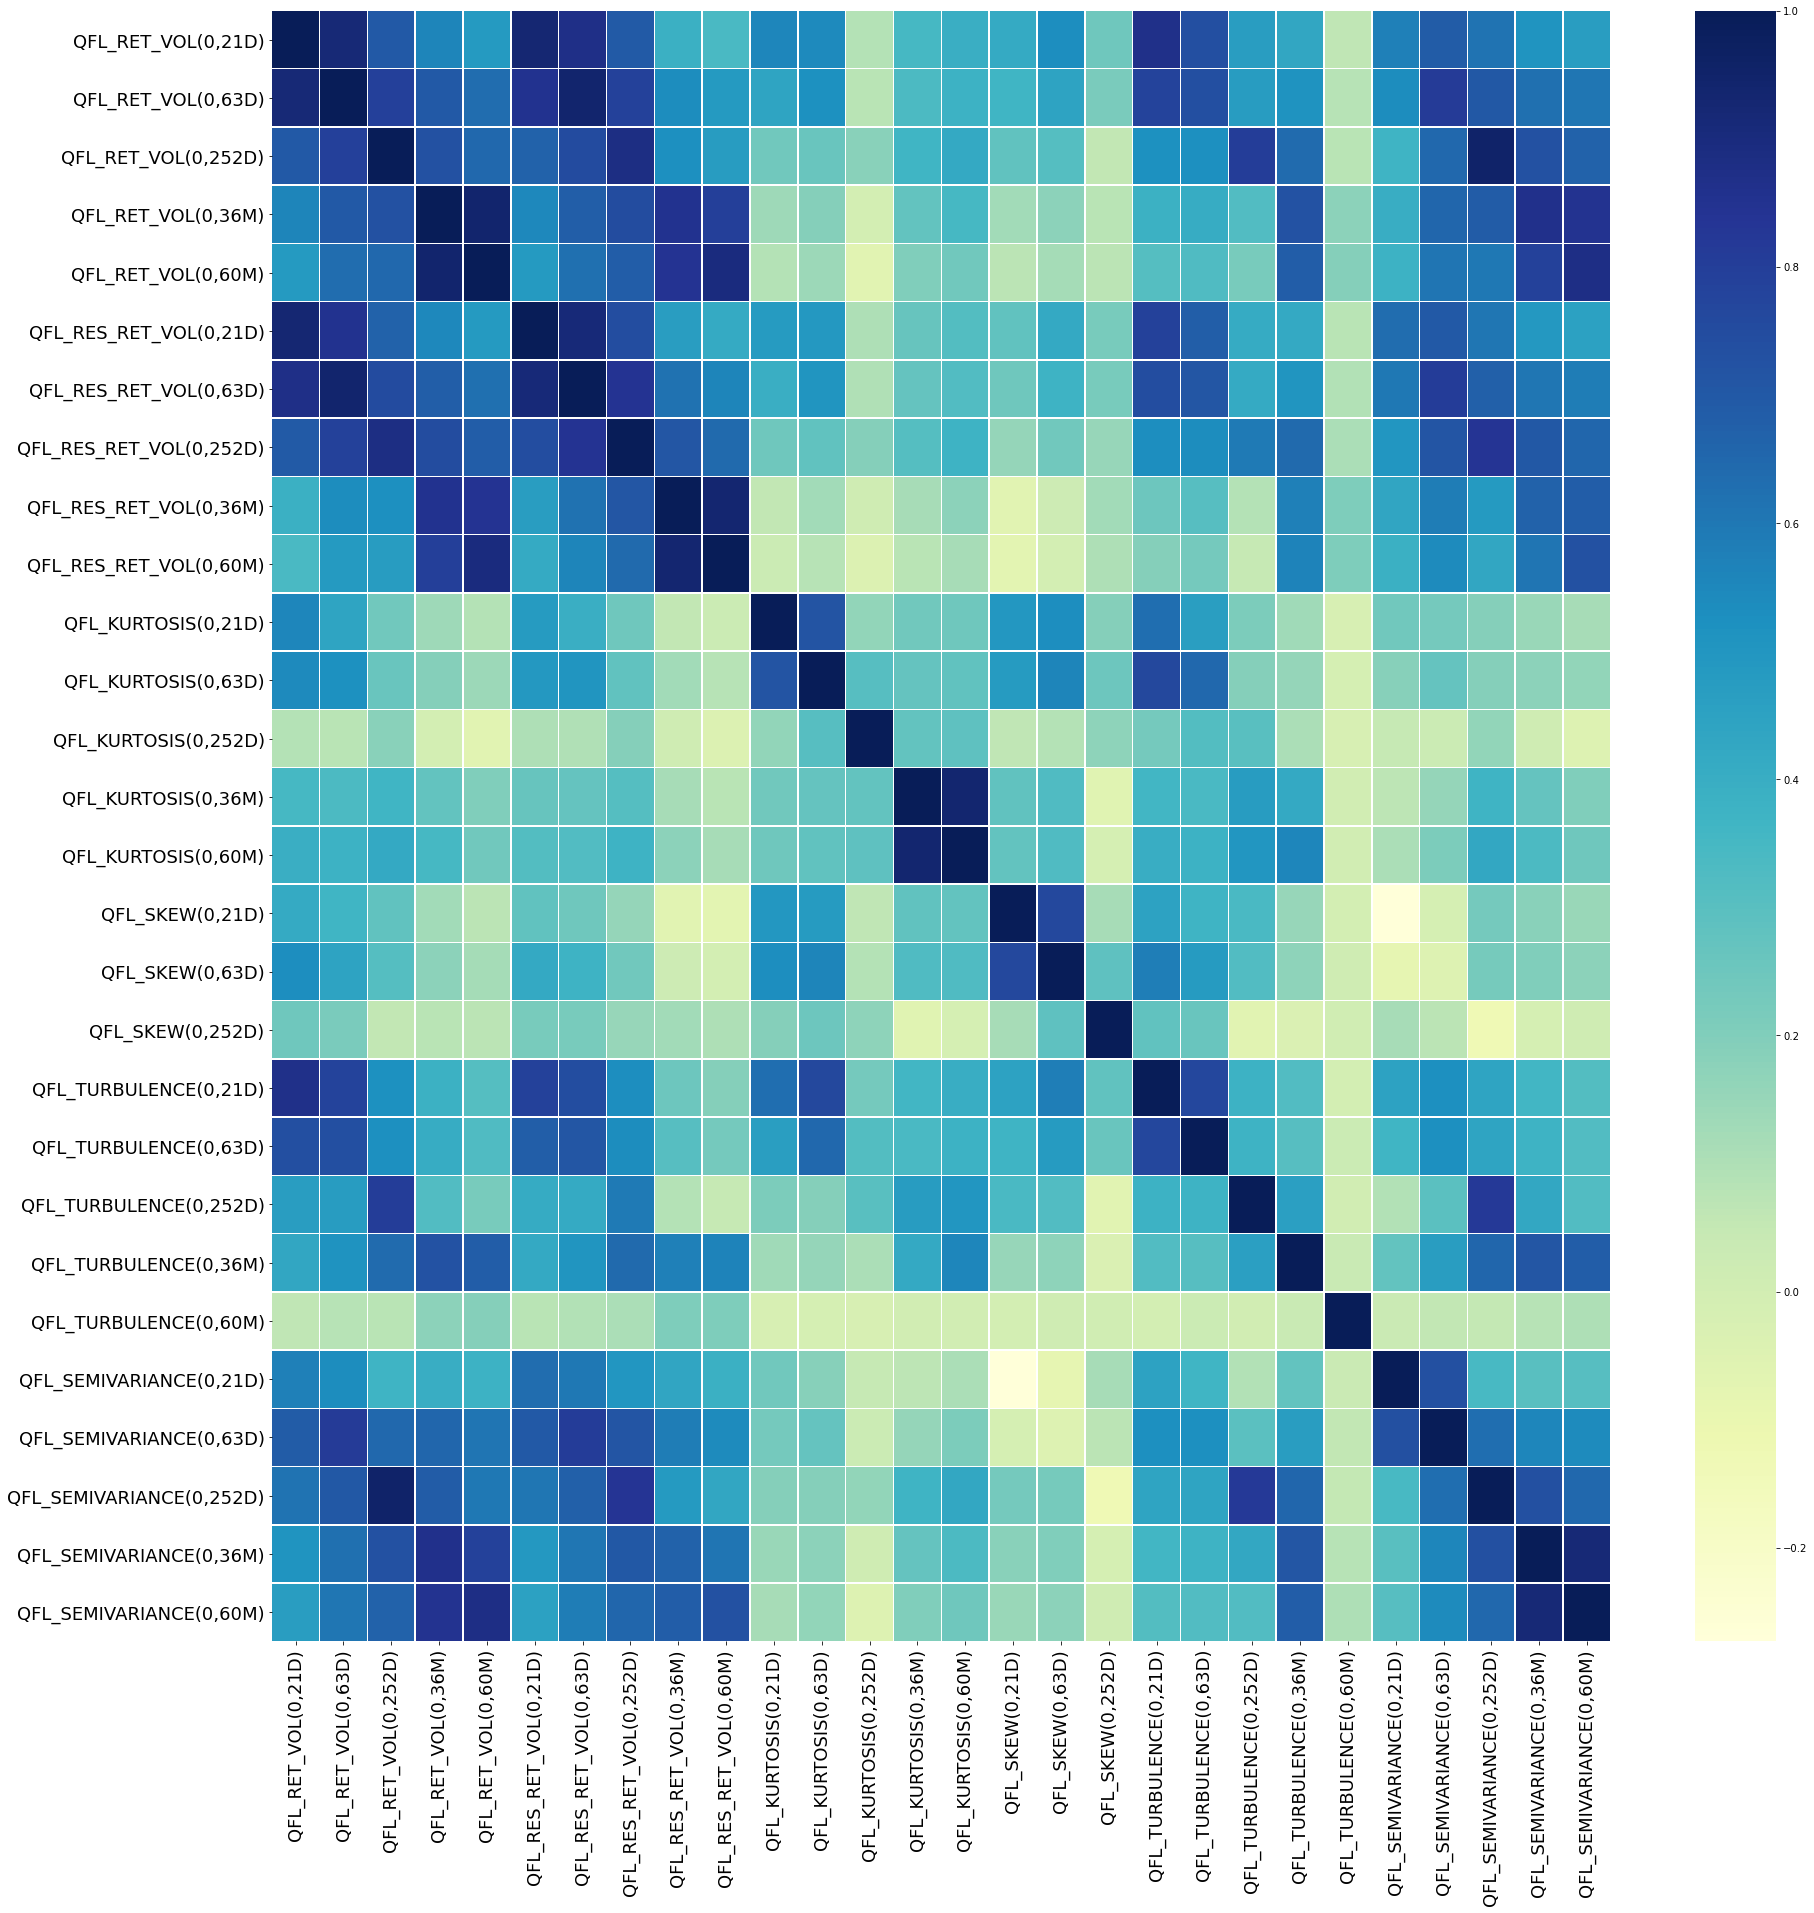

In [25]:
## Plot the correlation between each pair of factors

fig, ax = plt.subplots(figsize=(30,30))
hm = sns.heatmap(qfl_df[[c for c in qfl_df.columns[filter_idx]]].corr(), cmap="YlGnBu", annot = False, linewidths=.5, ax = ax)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 18, rotation=0)
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 18, rotation=90)
plt.show()

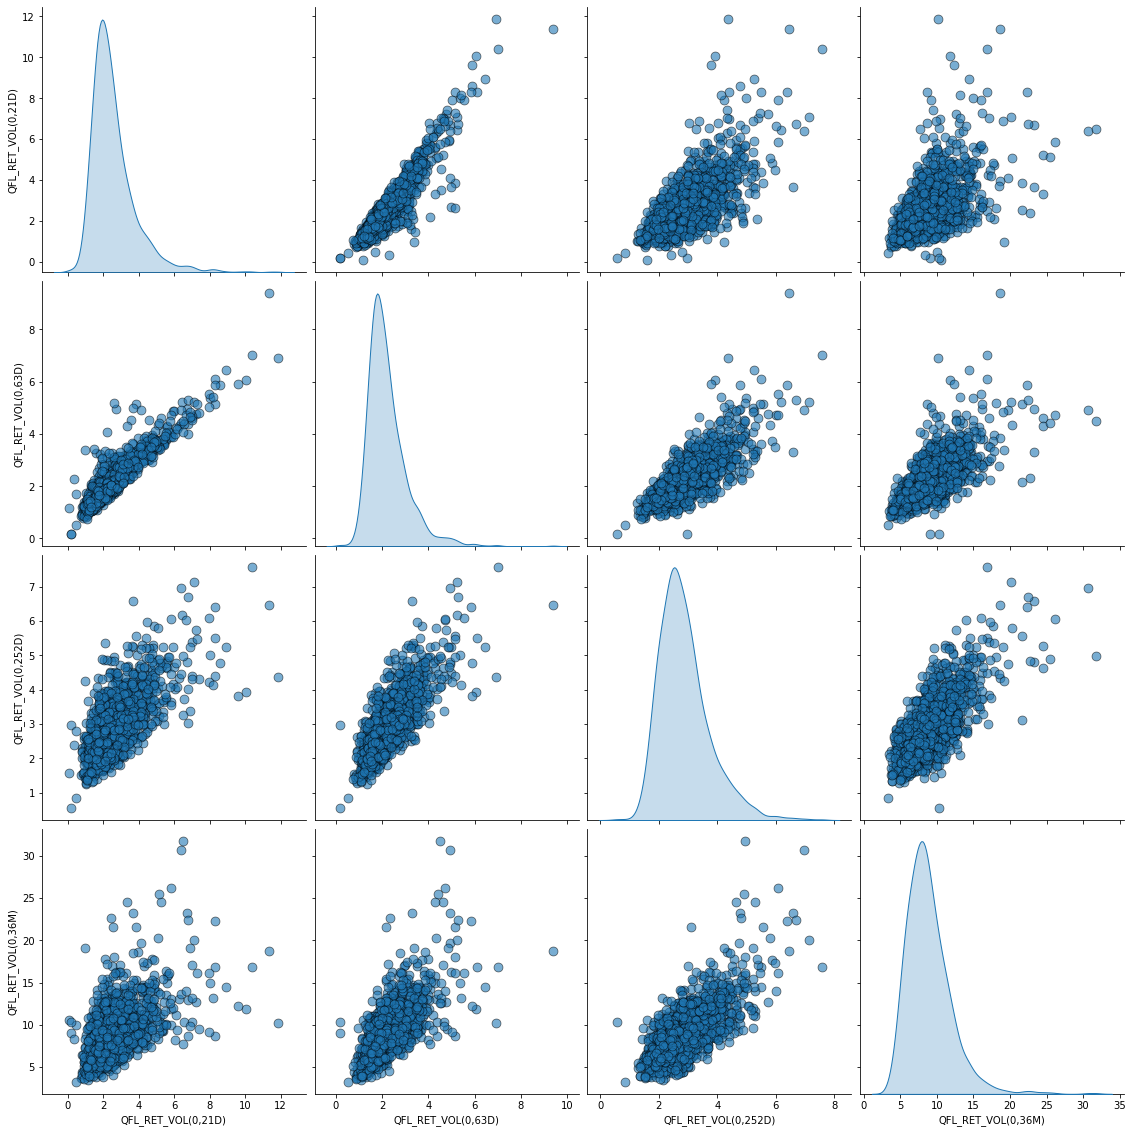

In [26]:
# Pairplot

sns.pairplot(qfl_df[qfl_df.columns[filter_idx[:4]].values], diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'}, height = 4);
#plt.show()

In [27]:
qfl_df[qfl_df.columns[filter_idx[:4]].values]

,"QFL_RET_VOL(0,21D)","QFL_RET_VOL(0,63D)","QFL_RET_VOL(0,252D)","QFL_RET_VOL(0,36M)"
0,1.736181,2.685291,2.904409,9.947263
1,1.856759,2.140169,2.757432,5.783602
2,2.299716,2.529494,2.421004,9.151896
3,2.515214,2.570025,2.873575,9.239359
4,1.636021,2.069769,2.403568,7.387337
...,...,...,...,...
1595,3.666189,2.388652,3.205599,7.857260
1596,1.272373,1.222057,1.598760,5.858628
1597,3.954408,2.742122,2.972032,8.892667
1598,3.374694,2.896792,3.155729,8.230336


In [28]:
# Other Statistics

advanced_describe = {}
stats_table = pd.DataFrame()
for factor in list(qfl_df.columns[filter_idx].values):
    advanced_describe[factor] = stats.describe(qfl_df[factor].dropna(), axis=0)    
    adv_stats = {keys: [np.round(series, 2) for series in values] for (keys, values) in zip(advanced_describe.keys(), advanced_describe.values())}
    stats_table = pd.DataFrame(adv_stats, index=['nobs', 'minmax', 'mean', 'variance', 'skewness', 'kurtosis']).T
stats_table

,nobs,minmax,mean,variance,skewness,kurtosis
"QFL_RET_VOL(0,21D)",1598,"[0.08, 11.87]",2.56,1.64,2.14,7.61
"QFL_RET_VOL(0,63D)",1596,"[0.17, 9.4]",2.2,0.72,1.86,6.59
"QFL_RET_VOL(0,252D)",1592,"[0.56, 7.58]",2.87,0.75,1.18,2.29
"QFL_RET_VOL(0,36M)",1551,"[3.24, 31.81]",8.89,9.66,1.74,6.44
"QFL_RET_VOL(0,60M)",1517,"[3.15, 32.51]",8.13,7.65,1.97,8.7
"QFL_RES_RET_VOL(0,21D)",1598,"[0.08, 11.54]",2.15,1.37,2.26,8.3
"QFL_RES_RET_VOL(0,63D)",1596,"[0.17, 8.1]",1.81,0.66,1.98,6.58
"QFL_RES_RET_VOL(0,252D)",1592,"[0.52, 6.28]",2.06,0.56,1.6,3.86
"QFL_RES_RET_VOL(0,36M)",1551,"[2.01, 31.21]",6.56,6.88,2.39,11.06
"QFL_RES_RET_VOL(0,60M)",1517,"[2.02, 31.84]",6.36,6.28,2.67,13.89


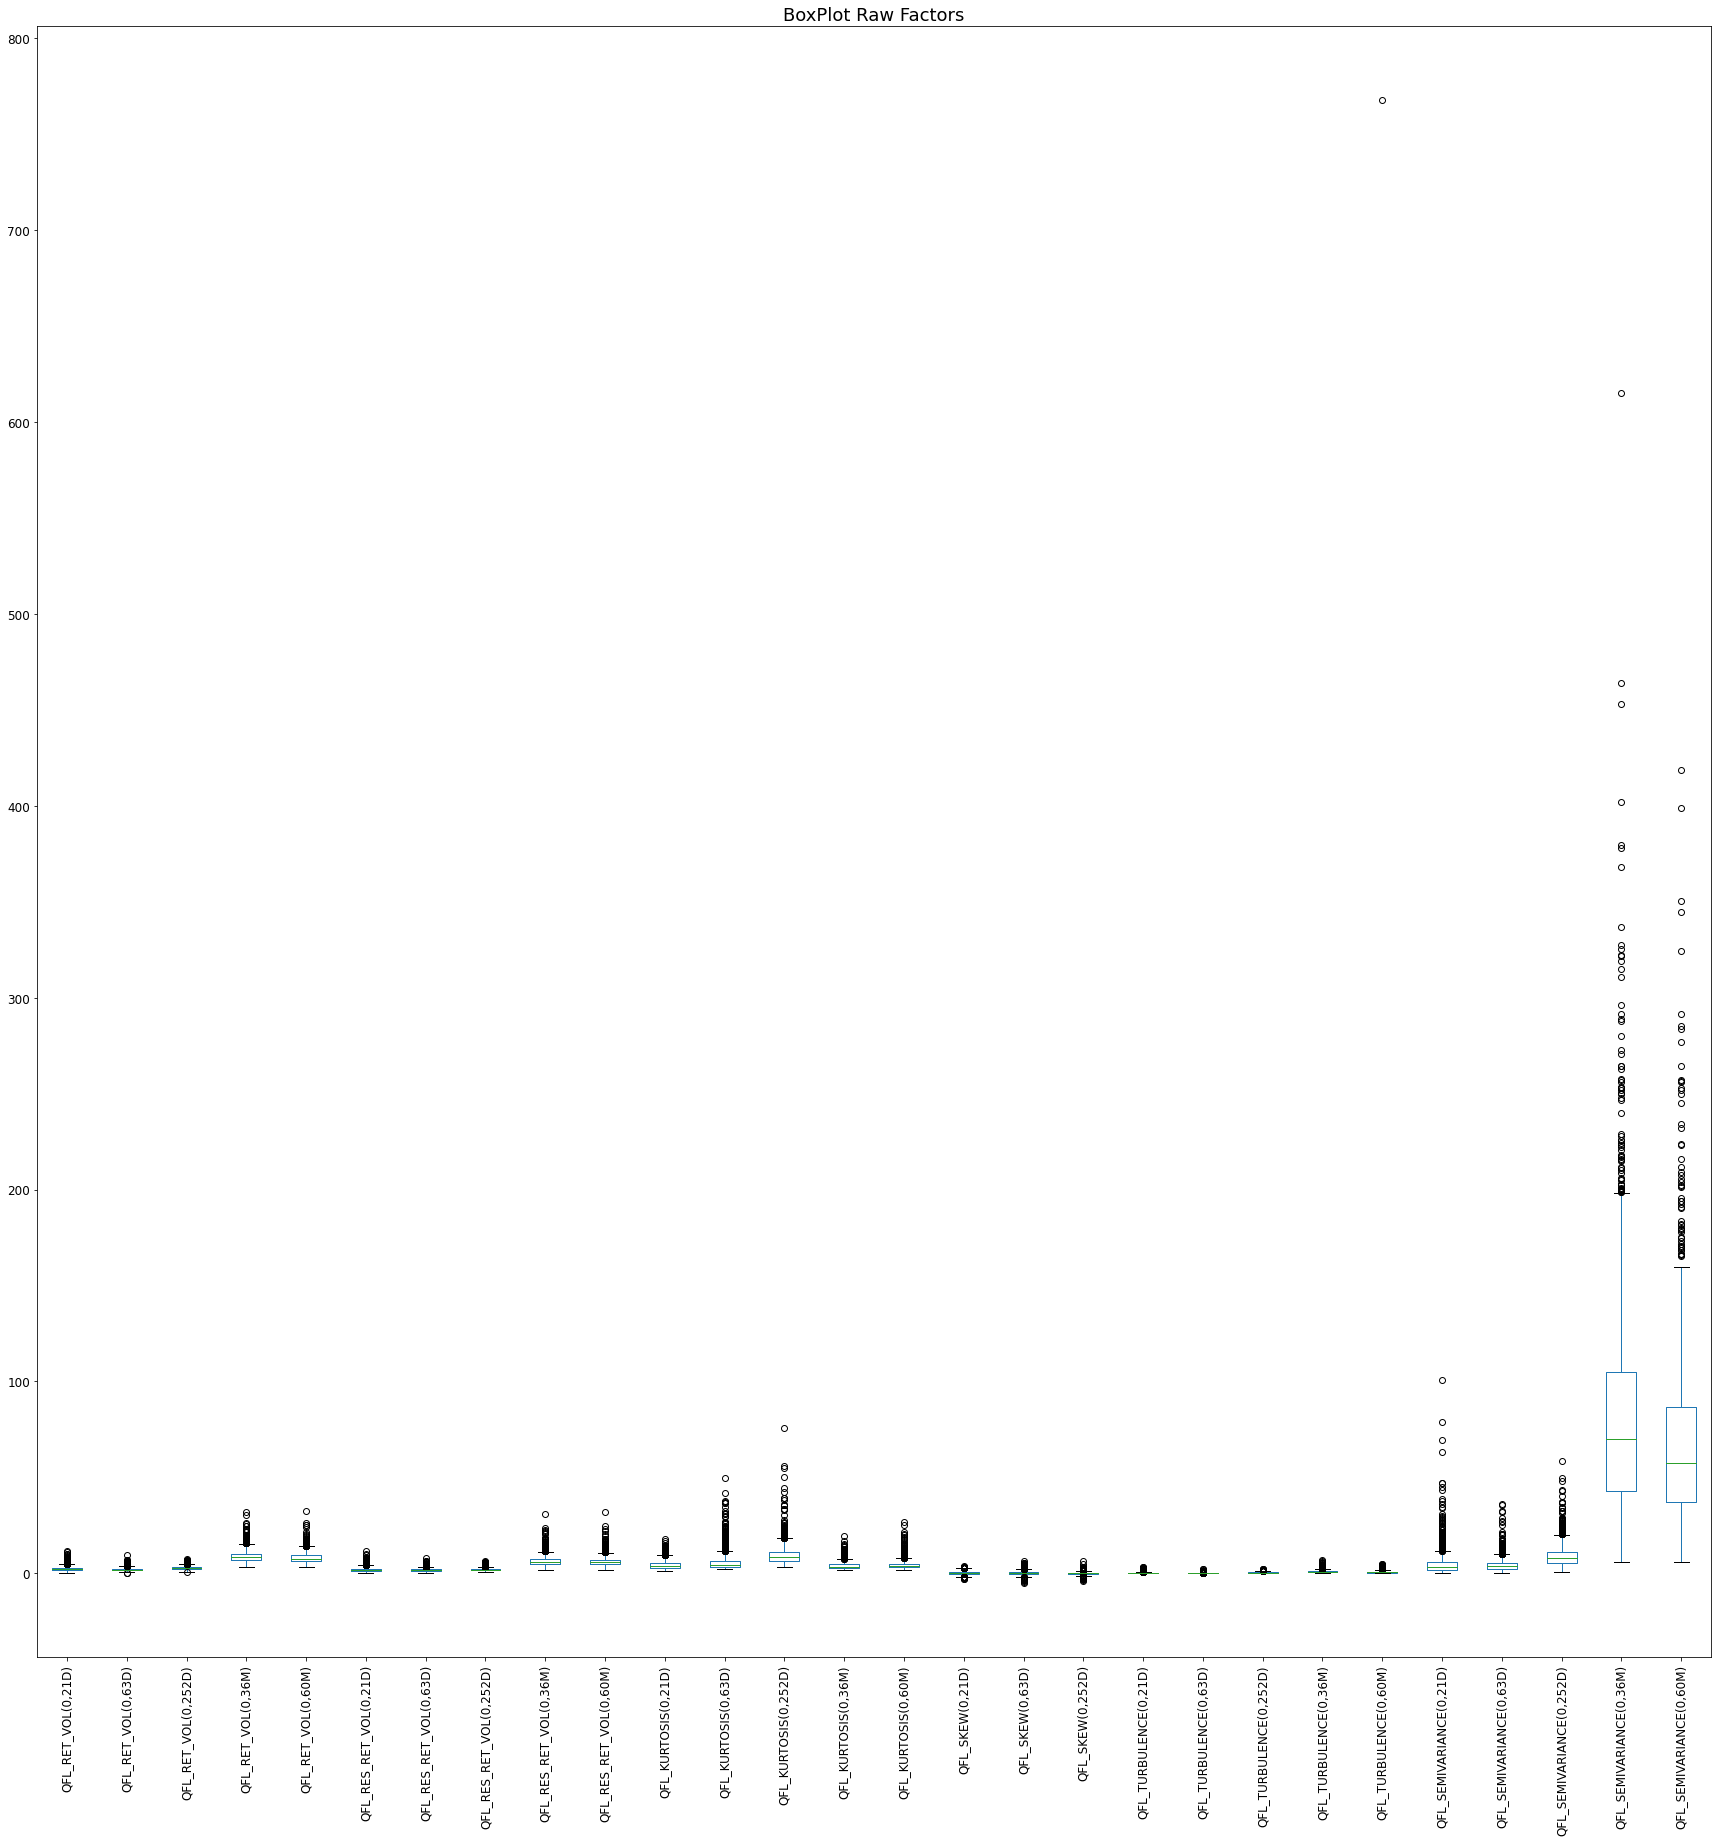

In [29]:
# Box-Whisker plot

qfl_df[qfl_df.columns[filter_idx]].boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Raw Factors', fontsize = 18);

In [30]:
# Z-Score

qfl_df_z = pd.DataFrame()

for factor in qfl_df[qfl_df.columns[filter_idx]]:
    z_score = ( qfl_df[factor] - qfl_df[factor].mean() ) / qfl_df[factor].std()
    qfl_df_z[factor] = z_score

qfl_df_z.describe()

,"QFL_RET_VOL(0,21D)","QFL_RET_VOL(0,63D)","QFL_RET_VOL(0,252D)","QFL_RET_VOL(0,36M)","QFL_RET_VOL(0,60M)","QFL_RES_RET_VOL(0,21D)","QFL_RES_RET_VOL(0,63D)","QFL_RES_RET_VOL(0,252D)","QFL_RES_RET_VOL(0,36M)","QFL_RES_RET_VOL(0,60M)","QFL_KURTOSIS(0,21D)","QFL_KURTOSIS(0,63D)","QFL_KURTOSIS(0,252D)","QFL_KURTOSIS(0,36M)","QFL_KURTOSIS(0,60M)","QFL_SKEW(0,21D)","QFL_SKEW(0,63D)","QFL_SKEW(0,252D)","QFL_TURBULENCE(0,21D)","QFL_TURBULENCE(0,63D)","QFL_TURBULENCE(0,252D)","QFL_TURBULENCE(0,36M)","QFL_TURBULENCE(0,60M)","QFL_SEMIVARIANCE(0,21D)","QFL_SEMIVARIANCE(0,63D)","QFL_SEMIVARIANCE(0,252D)","QFL_SEMIVARIANCE(0,36M)","QFL_SEMIVARIANCE(0,60M)"
count,1.598000e+03,1.596000e+03,1.592000e+03,1.551000e+03,1.517000e+03,1.598000e+03,1.596000e+03,1.592000e+03,1.551000e+03,1.517000e+03,1.598000e+03,1.596000e+03,1.592000e+03,1.551000e+03,1.517000e+03,1.598000e+03,1.596000e+03,1.592000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.487000e+03,1.394000e+03,1.598000e+03,1.596000e+03,1.592000e+03,1.551000e+03,1.517000e+03
mean,5.233611e-16,7.174016e-16,2.451034e-15,2.049761e-15,1.480249e-15,1.894396e-15,-7.983728e-16,-5.257868e-16,-1.417306e-17,3.627619e-16,-2.526278e-15,5.280516e-16,-6.389361e-16,2.055953e-15,3.957868e-16,-2.557404e-16,-3.068417e-16,5.857961e-18,2.114357e-15,-1.775662e-15,7.983462e-16,-8.060503e-16,1.684449e-17,-7.620115e-16,5.518073e-16,3.652160e-16,2.319944e-16,-1.559582e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.934586e+00,-2.398198e+00,-2.672482e+00,-1.815157e+00,-1.800421e+00,-1.770723e+00,-2.030804e+00,-2.054468e+00,-1.737140e+00,-1.734734e+00,-1.238045e+00,-8.230018e-01,-1.189759e+00,-1.155524e+00,-9.985306e-01,-3.542128e+00,-5.096827e+00,-5.781084e+00,-1.056188e+00,-1.001697e+00,-1.590847e+00,-1.190643e+00,-5.818276e-02,-7.757994e-01,-1.299624e+00,-1.441808e+00,-1.322222e+00,-1.370114e+00
25%,-6.402529e-01,-6.448821e-01,-6.871536e-01,-6.696479e-01,-6.617365e-01,-6.414649e-01,-6.546263e-01,-6.701549e-01,-6.432841e-01,-6.326719e-01,-7.131333e-01,-5.513491e-01,-5.944280e-01,-6.510999e-01,-5.899381e-01,-6.089019e-01,-5.531230e-01,-4.850749e-01,-6.088690e-01,-5.637397e-01,-7.331986e-01,-6.332788e-01,-4.306784e-02,-5.034138e-01,-5.949408e-01,-6.598904e-01,-6.856415e-01,-6.864715e-01
50%,-2.508524e-01,-2.233666e-01,-1.791960e-01,-1.596930e-01,-1.770667e-01,-2.330490e-01,-2.399375e-01,-2.399910e-01,-2.203188e-01,-2.251772e-01,-3.134577e-01,-3.378511e-01,-2.418245e-01,-3.320806e-01,-3.189476e-01,-7.742601e-02,-1.326258e-01,-1.277323e-03,-3.183355e-01,-2.756628e-01,-1.621584e-01,-2.579646e-01,-3.304576e-02,-2.773804e-01,-2.616672e-01,-2.374778e-01,-2.238346e-01,-2.346809e-01
75%,3.522367e-01,3.979965e-01,4.644480e-01,4.667664e-01,4.685640e-01,3.354578e-01,3.775219e-01,4.041940e-01,3.712315e-01,3.408674e-01,4.072393e-01,1.463806e-01,3.148698e-01,3.065818e-01,1.987340e-01,6.018532e-01,4.357676e-01,4.981263e-01,2.464717e-01,2.033096e-01,5.066974e-01,3.239886e-01,-1.853962e-02,1.235484e-01,2.715370e-01,3.590673e-01,3.767966e-01,3.998356e-01
max,7.279741e+00,8.481703e+00,5.434195e+00,7.376280e+00,8.816375e+00,8.021758e+00,7.762805e+00,5.668134e+00,9.396686e+00,1.016830e+01,5.563046e+00,9.379358e+00,1.271334e+01,7.484821e+00,8.680777e+00,3.509458e+00,5.822294e+00,8.824081e+00,8.448198e+00,1.030429e+01,5.242633e+00,8.342830e+00,3.729685e+01,1.496693e+01,9.042184e+00,8.486735e+00,9.119543e+00,7.669204e+00


In [31]:
# look for "extremely large" column's values after normalization (Descending)

for col_z in qfl_df_z:
    qfl_df_z[col_z] = qfl_df_z[col_z].sort_values(ignore_index=True, ascending = False)
    
qfl_df_z

,"QFL_RET_VOL(0,21D)","QFL_RET_VOL(0,63D)","QFL_RET_VOL(0,252D)","QFL_RET_VOL(0,36M)","QFL_RET_VOL(0,60M)","QFL_RES_RET_VOL(0,21D)","QFL_RES_RET_VOL(0,63D)","QFL_RES_RET_VOL(0,252D)","QFL_RES_RET_VOL(0,36M)","QFL_RES_RET_VOL(0,60M)","QFL_KURTOSIS(0,21D)","QFL_KURTOSIS(0,63D)","QFL_KURTOSIS(0,252D)","QFL_KURTOSIS(0,36M)","QFL_KURTOSIS(0,60M)","QFL_SKEW(0,21D)","QFL_SKEW(0,63D)","QFL_SKEW(0,252D)","QFL_TURBULENCE(0,21D)","QFL_TURBULENCE(0,63D)","QFL_TURBULENCE(0,252D)","QFL_TURBULENCE(0,36M)","QFL_TURBULENCE(0,60M)","QFL_SEMIVARIANCE(0,21D)","QFL_SEMIVARIANCE(0,63D)","QFL_SEMIVARIANCE(0,252D)","QFL_SEMIVARIANCE(0,36M)","QFL_SEMIVARIANCE(0,60M)"
0,7.279741,8.481703,5.434195,7.376280,8.816375,8.021758,7.762805,5.668134,9.396686,10.168297,5.563046,9.379358,12.713340,7.484821,8.680777,3.509458,5.822294,8.824081,8.448198,10.304292,5.242633,8.342830,37.296848,14.966928,9.042184,8.486735,9.119543,7.669204
1,6.877315,5.655796,4.913932,7.008578,6.523622,6.738581,6.024857,5.525052,6.570161,7.295289,5.103126,7.717545,8.930490,6.293849,7.970586,3.311811,4.922692,6.652897,8.368715,10.099430,5.196554,7.783433,0.185108,11.548474,8.928931,6.959448,6.526305,7.241813
2,6.118777,5.551092,4.708789,5.557576,6.181515,6.169468,5.986615,5.220432,6.166839,6.703993,4.829253,6.734714,8.725817,5.536739,6.664887,3.165793,4.671075,4.507718,7.299128,9.212683,5.164989,6.728814,0.175875,10.105778,8.027373,6.715841,6.338677,6.179673
3,5.848425,5.012913,4.419370,5.348406,6.096618,5.418016,5.119876,5.200452,5.977183,6.197254,4.391026,6.673768,7.856699,5.253486,6.173428,2.974966,4.599623,4.382539,6.228663,6.983885,4.354081,6.507242,0.161117,9.105134,7.856533,5.844391,5.464667,6.047941
4,5.504110,4.609435,4.294242,5.039683,5.757676,5.015026,4.979883,4.613761,5.820919,5.665387,4.168432,6.567683,6.700905,5.005833,5.905779,2.869257,4.428578,4.242434,6.103531,6.107312,4.204356,6.143565,0.155861,6.636881,6.922555,5.777832,5.083946,5.609121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,-1.854892,-2.398198,NaN,NaN,NaN,-1.687838,-2.030804,NaN,NaN,NaN,-1.176420,-0.823002,NaN,NaN,NaN,-2.969612,-5.096827,NaN,-1.004299,-0.981788,-1.562708,NaN,NaN,-0.766446,-1.299624,NaN,NaN,NaN
1596,-1.866170,NaN,NaN,NaN,NaN,-1.693547,NaN,NaN,NaN,NaN,-1.211324,NaN,NaN,NaN,NaN,-3.274046,NaN,NaN,-1.038071,-0.982578,-1.567423,NaN,NaN,-0.771308,NaN,NaN,NaN,NaN
1597,-1.934586,NaN,NaN,NaN,NaN,-1.770723,NaN,NaN,NaN,NaN,-1.238045,NaN,NaN,NaN,NaN,-3.542128,NaN,NaN,-1.056188,-1.001697,-1.590847,NaN,NaN,-0.775799,NaN,NaN,NaN,NaN
1598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# look for "extremely large" column's values after normalization (Ascending)

for col_z in qfl_df_z:
    qfl_df_z[col_z] = qfl_df_z[col_z].sort_values(ignore_index=True, ascending = True)
    
qfl_df_z

,"QFL_RET_VOL(0,21D)","QFL_RET_VOL(0,63D)","QFL_RET_VOL(0,252D)","QFL_RET_VOL(0,36M)","QFL_RET_VOL(0,60M)","QFL_RES_RET_VOL(0,21D)","QFL_RES_RET_VOL(0,63D)","QFL_RES_RET_VOL(0,252D)","QFL_RES_RET_VOL(0,36M)","QFL_RES_RET_VOL(0,60M)","QFL_KURTOSIS(0,21D)","QFL_KURTOSIS(0,63D)","QFL_KURTOSIS(0,252D)","QFL_KURTOSIS(0,36M)","QFL_KURTOSIS(0,60M)","QFL_SKEW(0,21D)","QFL_SKEW(0,63D)","QFL_SKEW(0,252D)","QFL_TURBULENCE(0,21D)","QFL_TURBULENCE(0,63D)","QFL_TURBULENCE(0,252D)","QFL_TURBULENCE(0,36M)","QFL_TURBULENCE(0,60M)","QFL_SEMIVARIANCE(0,21D)","QFL_SEMIVARIANCE(0,63D)","QFL_SEMIVARIANCE(0,252D)","QFL_SEMIVARIANCE(0,36M)","QFL_SEMIVARIANCE(0,60M)"
0,-1.934586,-2.398198,-2.672482,-1.815157,-1.800421,-1.770723,-2.030804,-2.054468,-1.737140,-1.734734,-1.238045,-0.823002,-1.189759,-1.155524,-0.998531,-3.542128,-5.096827,-5.781084,-1.056188,-1.001697,-1.590847,-1.190643,-0.058183,-0.775799,-1.299624,-1.441808,-1.322222,-1.370114
1,-1.866170,-2.381580,-2.351300,-1.746696,-1.670267,-1.693547,-2.029707,-2.044760,-1.674087,-1.656805,-1.211324,-0.822626,-1.160424,-1.141787,-0.990068,-3.274046,-4.628277,-5.089375,-1.038071,-0.982578,-1.567423,-1.173195,-0.056893,-0.771308,-1.287625,-1.440177,-1.304224,-1.328449
2,-1.854892,-1.997817,-1.858544,-1.692794,-1.662490,-1.687838,-1.654886,-2.003981,-1.654864,-1.571815,-1.176420,-0.821804,-1.155855,-1.126573,-0.986683,-2.969612,-4.254890,-4.122855,-1.004299,-0.981788,-1.562708,-1.162531,-0.056520,-0.766446,-1.234080,-1.324588,-1.270094,-1.284855
3,-1.749531,-1.734953,-1.831435,-1.673136,-1.660787,-1.582870,-1.616986,-1.825744,-1.568918,-1.499592,-1.170843,-0.818129,-1.147622,-1.115859,-0.981835,-2.936357,-3.552426,-3.788722,-0.972710,-0.955150,-1.555455,-1.160817,-0.056515,-0.764709,-1.157833,-1.301019,-1.262588,-1.277345
4,-1.647396,-1.675186,-1.815855,-1.657933,-1.635426,-1.480064,-1.611989,-1.795271,-1.521868,-1.451220,-1.167594,-0.810255,-1.139423,-1.080931,-0.975287,-2.807616,-3.522339,-3.787072,-0.948857,-0.942942,-1.544844,-1.153988,-0.056272,-0.759163,-1.155441,-1.285737,-1.262283,-1.275786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,6.118777,8.481703,NaN,NaN,NaN,6.169468,7.762805,NaN,NaN,NaN,4.829253,9.379358,NaN,NaN,NaN,3.165793,5.822294,NaN,7.299128,9.212683,5.164989,NaN,NaN,10.105778,9.042184,NaN,NaN,NaN
1596,6.877315,NaN,NaN,NaN,NaN,6.738581,NaN,NaN,NaN,NaN,5.103126,NaN,NaN,NaN,NaN,3.311811,NaN,NaN,8.368715,10.099430,5.196554,NaN,NaN,11.548474,NaN,NaN,NaN,NaN
1597,7.279741,NaN,NaN,NaN,NaN,8.021758,NaN,NaN,NaN,NaN,5.563046,NaN,NaN,NaN,NaN,3.509458,NaN,NaN,8.448198,10.304292,5.242633,NaN,NaN,14.966928,NaN,NaN,NaN,NaN
1598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


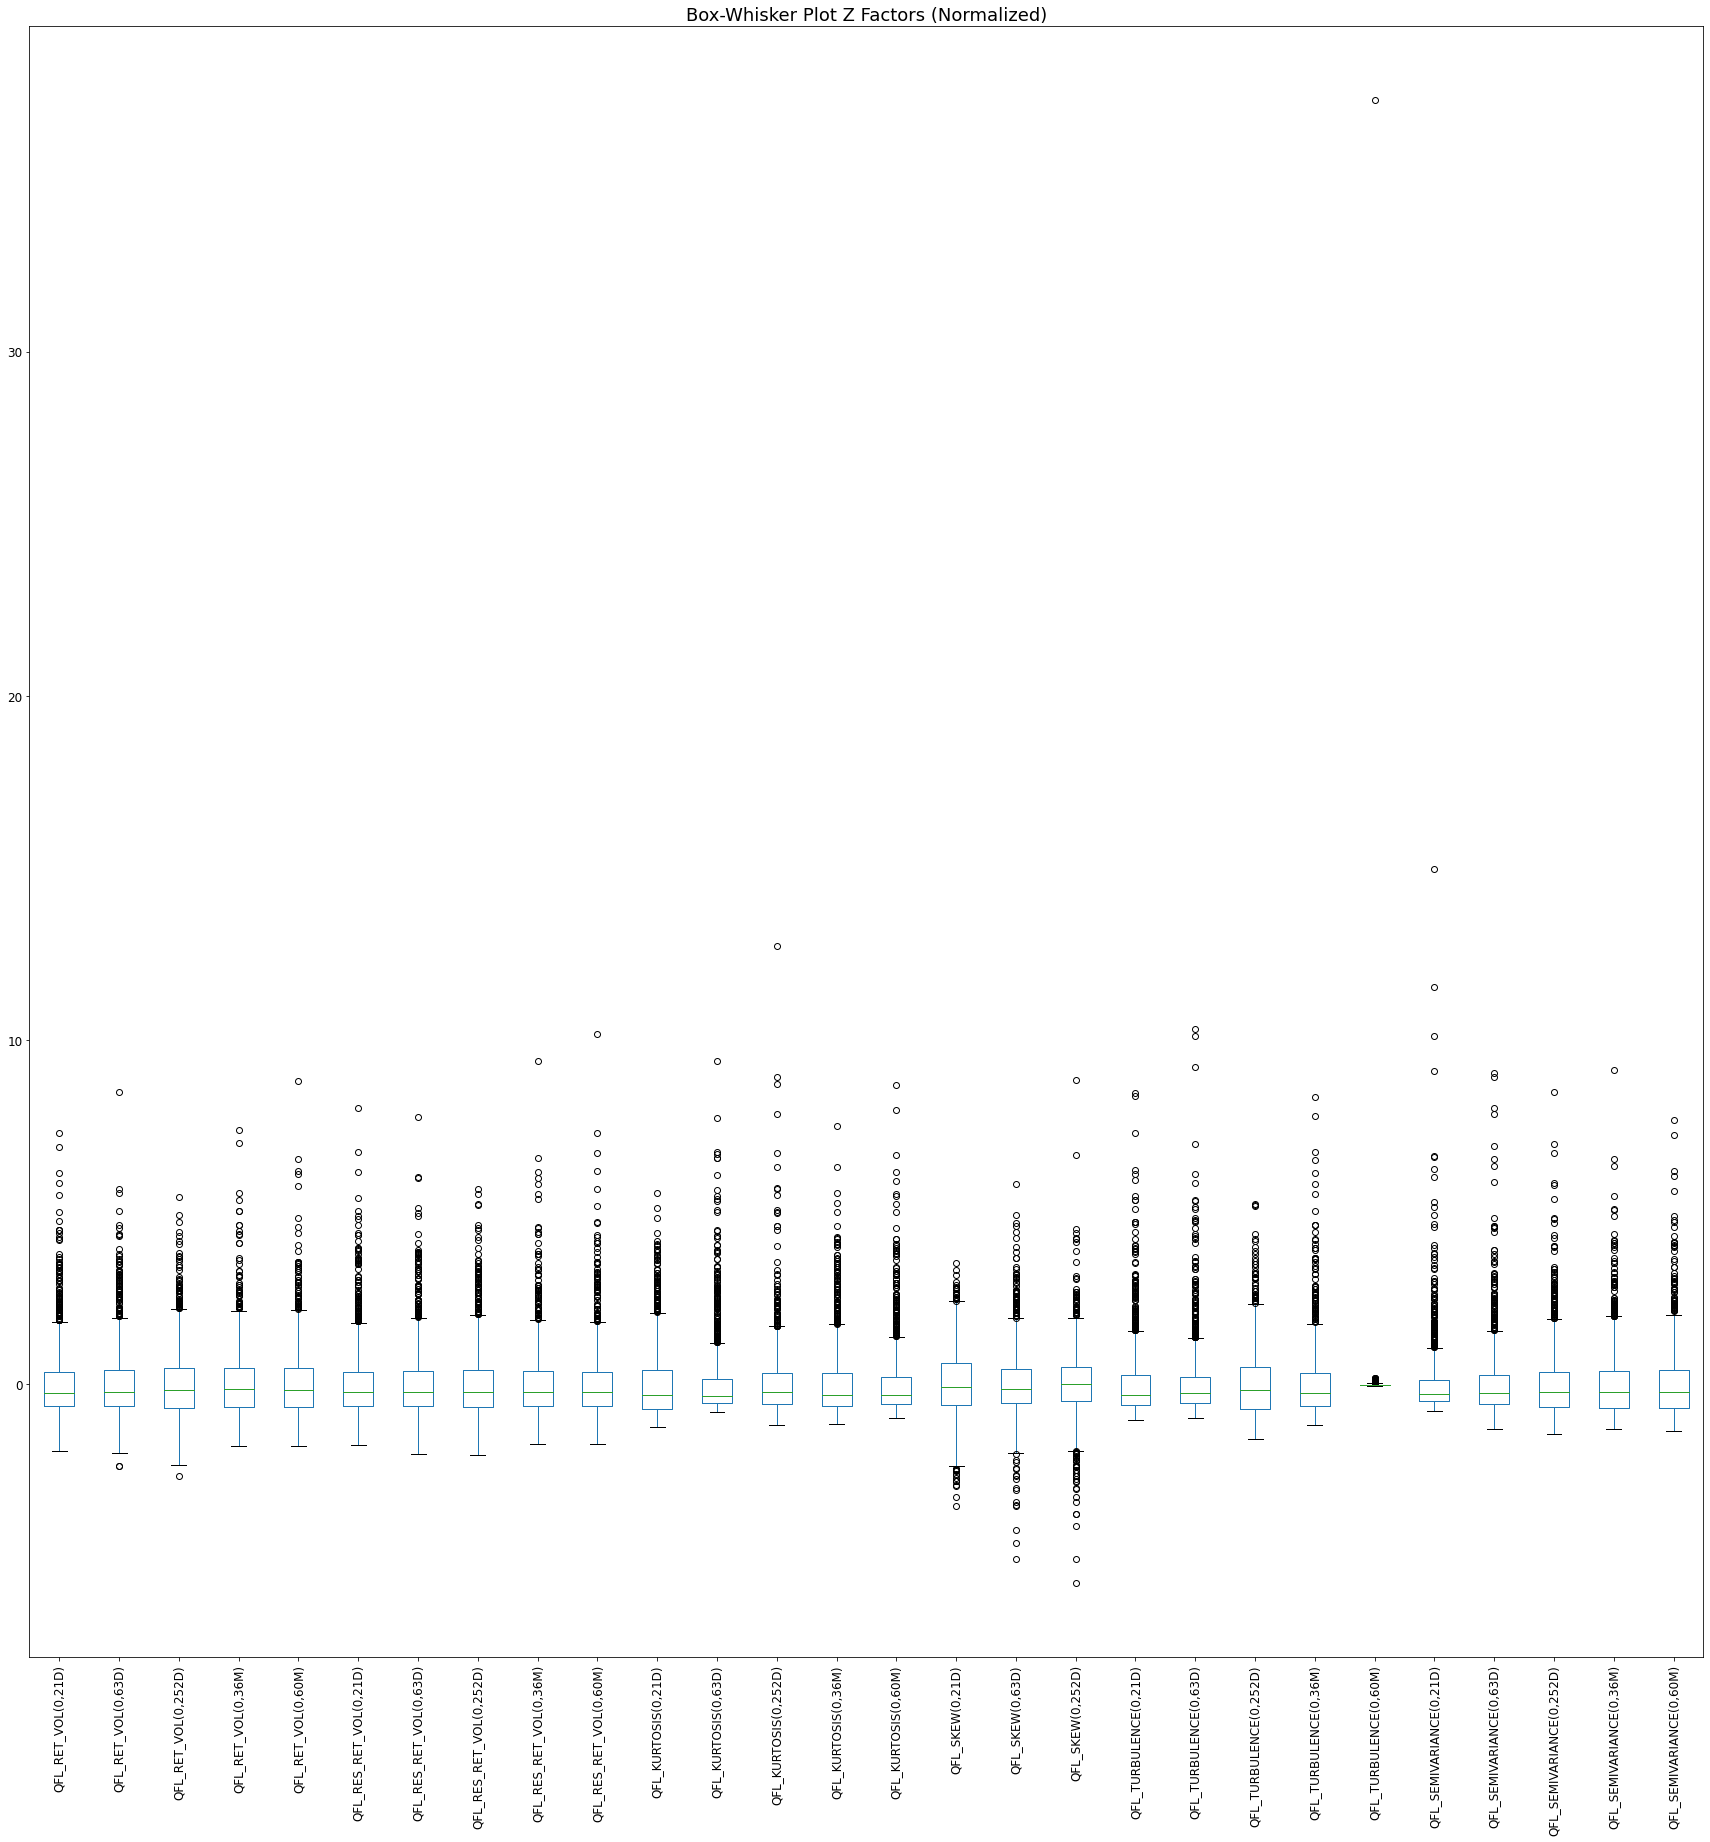

In [33]:
# Box-Whisker plot (Normalized data)

qfl_df_z.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('Box-Whisker Plot Z Factors (Normalized)', fontsize = 18);

In [34]:
# Greedy Multi-Factor Simple Average from all Multi-Factor's components

# MFR Z-Score

qfl_df_z['MFR'] = qfl_df_z.mean(axis = 1)

qfl_df_z.head()

,"QFL_RET_VOL(0,21D)","QFL_RET_VOL(0,63D)","QFL_RET_VOL(0,252D)","QFL_RET_VOL(0,36M)","QFL_RET_VOL(0,60M)","QFL_RES_RET_VOL(0,21D)","QFL_RES_RET_VOL(0,63D)","QFL_RES_RET_VOL(0,252D)","QFL_RES_RET_VOL(0,36M)","QFL_RES_RET_VOL(0,60M)","QFL_KURTOSIS(0,21D)","QFL_KURTOSIS(0,63D)","QFL_KURTOSIS(0,252D)","QFL_KURTOSIS(0,36M)","QFL_KURTOSIS(0,60M)","QFL_SKEW(0,21D)","QFL_SKEW(0,63D)","QFL_SKEW(0,252D)","QFL_TURBULENCE(0,21D)","QFL_TURBULENCE(0,63D)","QFL_TURBULENCE(0,252D)","QFL_TURBULENCE(0,36M)","QFL_TURBULENCE(0,60M)","QFL_SEMIVARIANCE(0,21D)","QFL_SEMIVARIANCE(0,63D)","QFL_SEMIVARIANCE(0,252D)","QFL_SEMIVARIANCE(0,36M)","QFL_SEMIVARIANCE(0,60M)",MFR
0,-1.934586,-2.398198,-2.672482,-1.815157,-1.800421,-1.770723,-2.030804,-2.054468,-1.737140,-1.734734,-1.238045,-0.823002,-1.189759,-1.155524,-0.998531,-3.542128,-5.096827,-5.781084,-1.056188,-1.001697,-1.590847,-1.190643,-0.058183,-0.775799,-1.299624,-1.441808,-1.322222,-1.370114,-1.817169
1,-1.866170,-2.381580,-2.351300,-1.746696,-1.670267,-1.693547,-2.029707,-2.044760,-1.674087,-1.656805,-1.211324,-0.822626,-1.160424,-1.141787,-0.990068,-3.274046,-4.628277,-5.089375,-1.038071,-0.982578,-1.567423,-1.173195,-0.056893,-0.771308,-1.287625,-1.440177,-1.304224,-1.328449,-1.727957
2,-1.854892,-1.997817,-1.858544,-1.692794,-1.662490,-1.687838,-1.654886,-2.003981,-1.654864,-1.571815,-1.176420,-0.821804,-1.155855,-1.126573,-0.986683,-2.969612,-4.254890,-4.122855,-1.004299,-0.981788,-1.562708,-1.162531,-0.056520,-0.766446,-1.234080,-1.324588,-1.270094,-1.284855,-1.603662
3,-1.749531,-1.734953,-1.831435,-1.673136,-1.660787,-1.582870,-1.616986,-1.825744,-1.568918,-1.499592,-1.170843,-0.818129,-1.147622,-1.115859,-0.981835,-2.936357,-3.552426,-3.788722,-0.972710,-0.955150,-1.555455,-1.160817,-0.056515,-0.764709,-1.157833,-1.301019,-1.262588,-1.277345,-1.525710
4,-1.647396,-1.675186,-1.815855,-1.657933,-1.635426,-1.480064,-1.611989,-1.795271,-1.521868,-1.451220,-1.167594,-0.810255,-1.139423,-1.080931,-0.975287,-2.807616,-3.522339,-3.787072,-0.948857,-0.942942,-1.544844,-1.153988,-0.056272,-0.759163,-1.155441,-1.285737,-1.262283,-1.275786,-1.498859


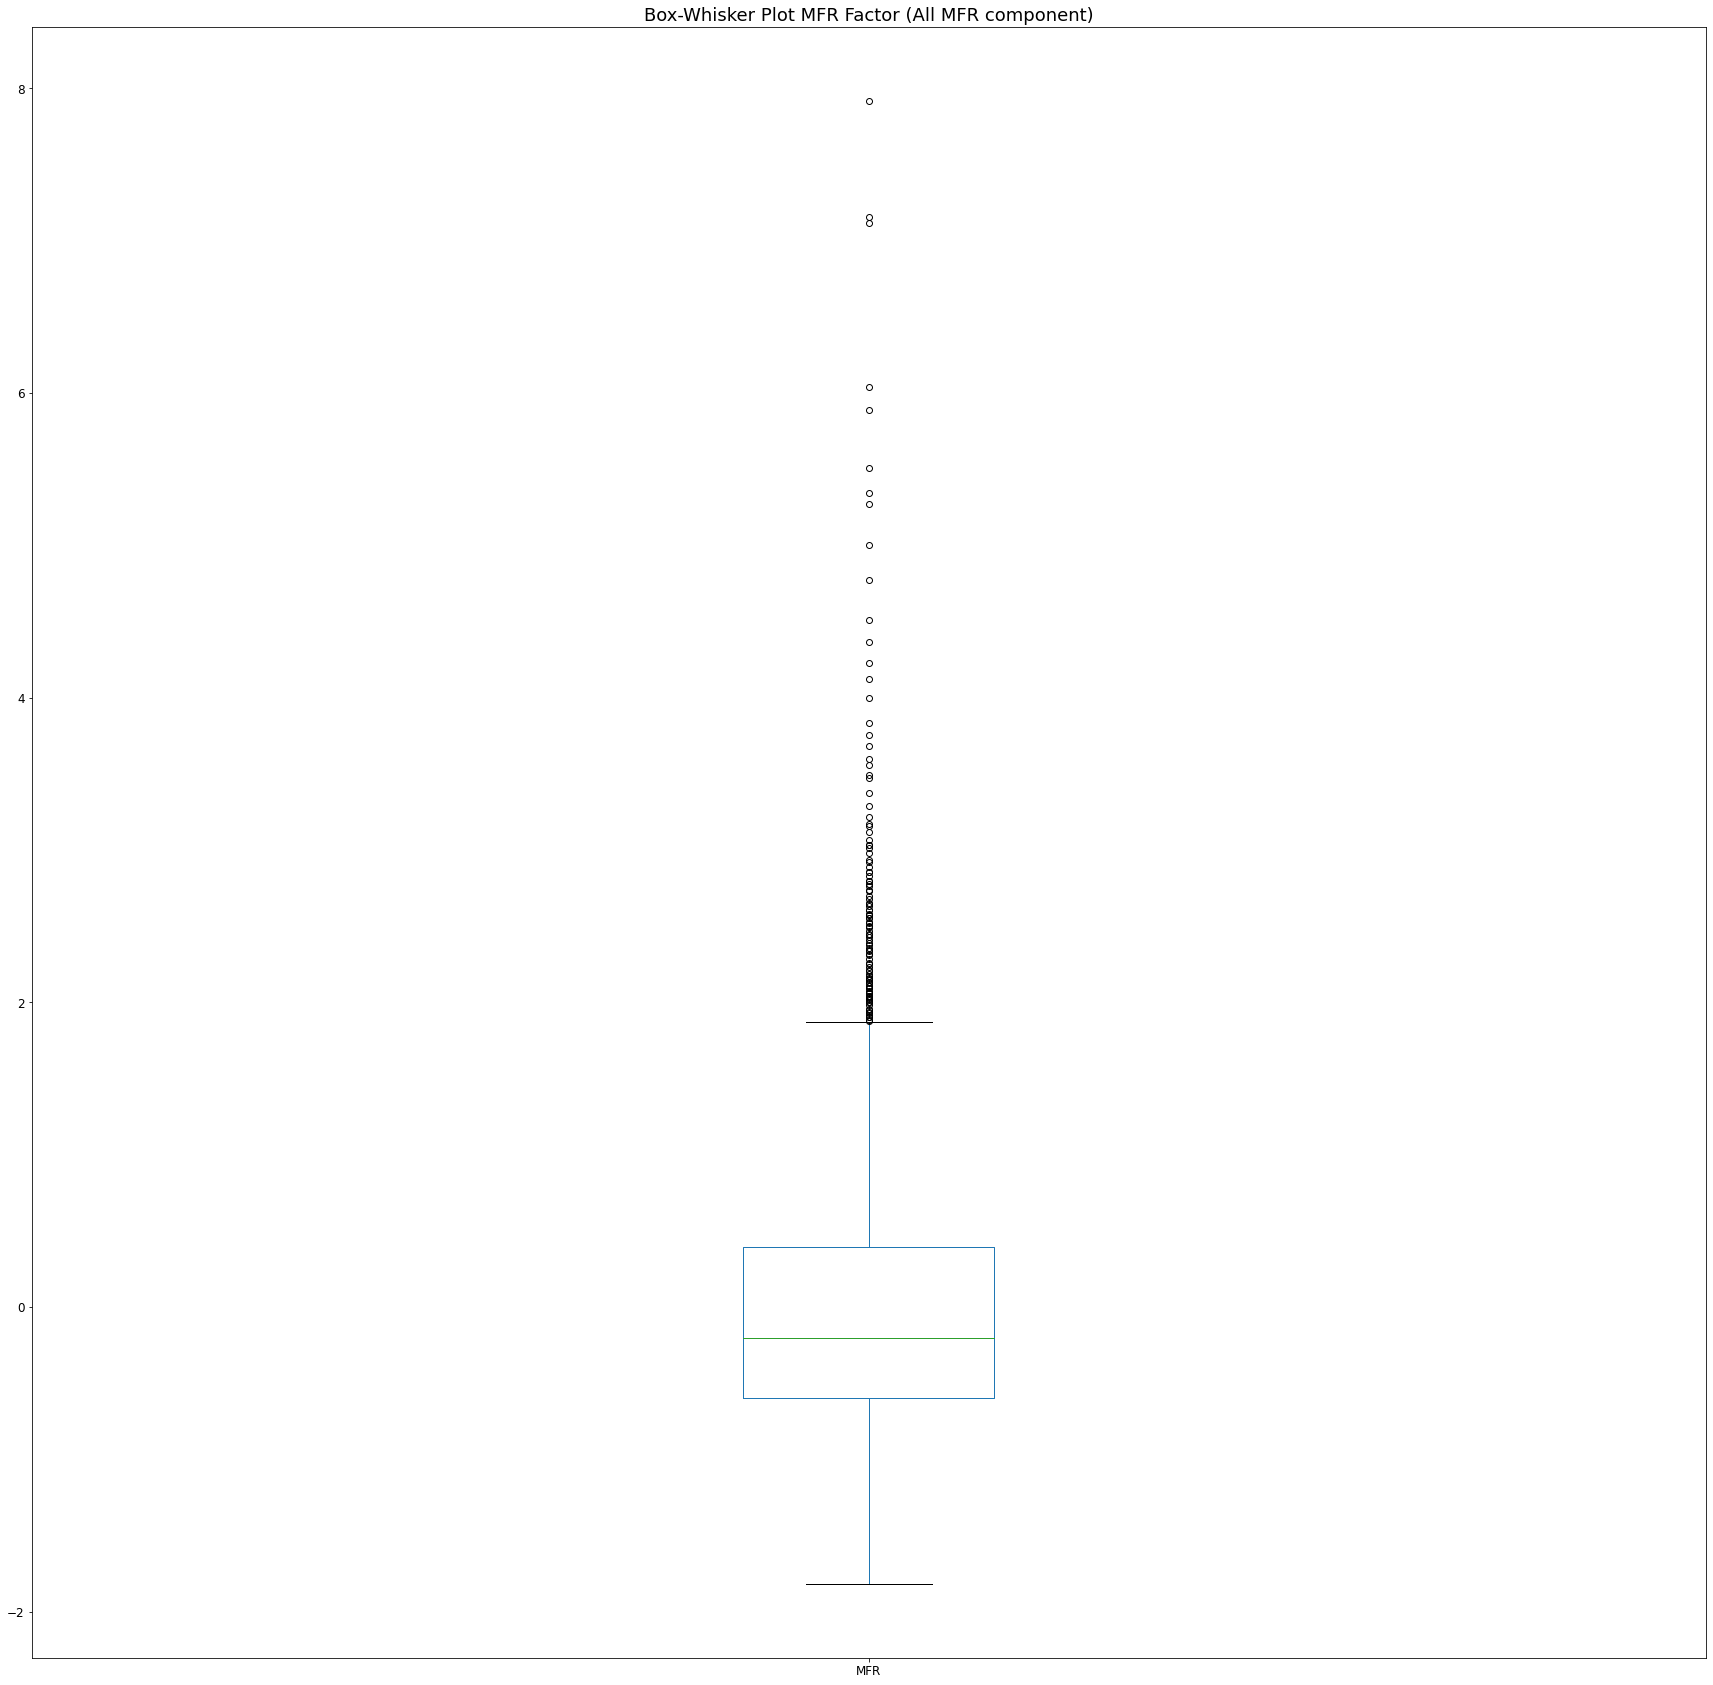

In [35]:
pd.DataFrame(qfl_df_z['MFR']).boxplot(grid=False, fontsize=12, figsize = (30,30)).set_title('Box-Whisker Plot MFR Factor (All MFR component)', fontsize = 18);

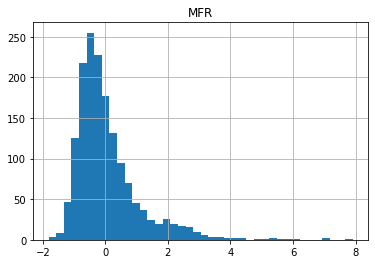

In [36]:
# MFR Distribution

pd.DataFrame(qfl_df_z['MFR']).hist(bins = int(np.sqrt(len(qfl_df_z['MFR']))));

In [37]:
# Check Infomation Coefficient: MFR (Components: All, Z-Scored Only)

sp_corr_z, sp_pval_z = stats.spearmanr(-qfl_df_z['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z,2)))

Information Coefficient: 0.05
Information Coefficient (P-Value): 0.04


C:\Users\ffais\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


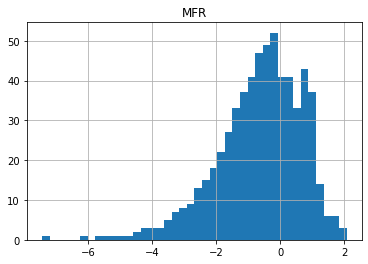

In [38]:
# MFR Log-Distribution

pd.DataFrame(np.log(qfl_df_z['MFR'])).hist(bins = int(np.sqrt(len(qfl_df_z['MFR']))));

In [39]:
# Log-Transformation for positive/not-zero features

qfl_df_log = pd.DataFrame()

for col_pos in qfl_df[qfl_df.columns[filter_idx]]:
    if np.sum(qfl_df[qfl_df.columns[filter_idx]][col_pos] <= 0) == 0:
        qfl_df_log[col_pos] = np.log(qfl_df[qfl_df.columns[filter_idx]][col_pos])
    else:
        qfl_df_log[col_pos] = qfl_df[qfl_df.columns[filter_idx]][col_pos]
    
qfl_df_log

,"QFL_RET_VOL(0,21D)","QFL_RET_VOL(0,63D)","QFL_RET_VOL(0,252D)","QFL_RET_VOL(0,36M)","QFL_RET_VOL(0,60M)","QFL_RES_RET_VOL(0,21D)","QFL_RES_RET_VOL(0,63D)","QFL_RES_RET_VOL(0,252D)","QFL_RES_RET_VOL(0,36M)","QFL_RES_RET_VOL(0,60M)","QFL_KURTOSIS(0,21D)","QFL_KURTOSIS(0,63D)","QFL_KURTOSIS(0,252D)","QFL_KURTOSIS(0,36M)","QFL_KURTOSIS(0,60M)","QFL_SKEW(0,21D)","QFL_SKEW(0,63D)","QFL_SKEW(0,252D)","QFL_TURBULENCE(0,21D)","QFL_TURBULENCE(0,63D)","QFL_TURBULENCE(0,252D)","QFL_TURBULENCE(0,36M)","QFL_TURBULENCE(0,60M)","QFL_SEMIVARIANCE(0,21D)","QFL_SEMIVARIANCE(0,63D)","QFL_SEMIVARIANCE(0,252D)","QFL_SEMIVARIANCE(0,36M)","QFL_SEMIVARIANCE(0,60M)"
0,0.551688,0.987789,1.066230,2.297297,2.192461,0.411706,0.498421,0.468210,1.957439,1.905353,1.078650,1.282077,1.936220,1.132046,1.188146,0.326973,-0.442925,-0.071032,-1.361777,-2.159186,-0.689145,-0.056866,-0.552744,0.579672,2.182554,2.192158,4.310686,4.187370
1,0.618832,0.760885,1.014300,1.755027,1.692411,0.319334,0.097706,0.252732,1.208375,1.339174,1.242880,1.282998,2.242742,0.959075,1.040776,0.434648,-0.471974,-0.071315,-1.779201,-3.036325,-0.518344,-0.593324,-1.215435,0.891069,1.851053,2.157275,3.444395,3.311360
2,0.832786,0.928019,0.884182,2.213961,2.111040,0.734167,0.560399,0.649138,1.936390,1.864387,1.544408,1.083899,1.444755,1.501761,1.517084,0.286507,0.166507,0.091652,-1.953373,-2.167058,-1.019373,-0.812595,-1.126984,1.528506,1.905149,1.752208,4.388356,4.177397
3,0.922358,0.943916,1.055557,2.223473,2.066867,0.728730,0.621595,0.643546,1.792129,1.783685,1.905531,1.387210,1.889403,1.161413,1.320625,1.153225,0.259757,-0.229315,-1.261168,-2.016782,-0.842237,0.047648,NaN,1.189372,1.842514,2.213710,4.213267,3.954881
4,0.492267,0.727437,0.876954,1.999767,1.879383,0.097216,0.205382,0.225770,1.528548,1.525738,2.025569,1.295224,1.914782,0.987432,1.052623,1.679069,-0.229834,-0.228666,-1.366794,-2.013549,-1.058727,-0.530272,NaN,0.094147,1.690257,1.971454,4.022636,3.846540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,1.299153,0.870729,1.164899,2.061438,1.889139,1.217073,0.784432,0.821129,1.435601,1.469498,2.706199,3.381003,2.803195,2.559514,2.716823,3.232153,4.232227,-1.163739,0.033961,-0.692002,-0.002272,0.443357,-0.248254,0.342337,0.582330,2.472147,4.286138,3.851593
1596,0.240884,0.200536,0.469228,1.767915,1.895175,0.090693,-0.040441,0.268453,1.546820,1.723559,0.902507,1.095249,1.663721,0.681380,1.248139,-0.058764,0.061296,0.398220,-1.913365,-2.055514,-2.210143,-0.375530,-0.412683,0.871133,0.729140,0.943958,3.894934,4.117057
1597,1.374831,1.008732,1.089246,2.185227,1.969427,1.215563,0.887133,0.897694,1.705102,1.568758,2.308657,2.933875,2.411039,2.332397,2.664535,2.355033,2.939509,-0.554925,0.044974,-0.764809,-0.233681,0.501715,-0.079897,1.053282,1.318837,2.399109,4.275168,3.911880
1598,1.216305,1.063604,1.149220,2.107827,2.482152,1.135048,0.886053,0.791188,1.874559,2.336961,1.090615,1.171362,1.446075,0.825968,1.736144,0.447771,0.413380,0.168037,-1.235078,-1.303406,-0.809681,0.986962,-0.135174,2.402835,2.205881,2.373343,4.512834,4.989534


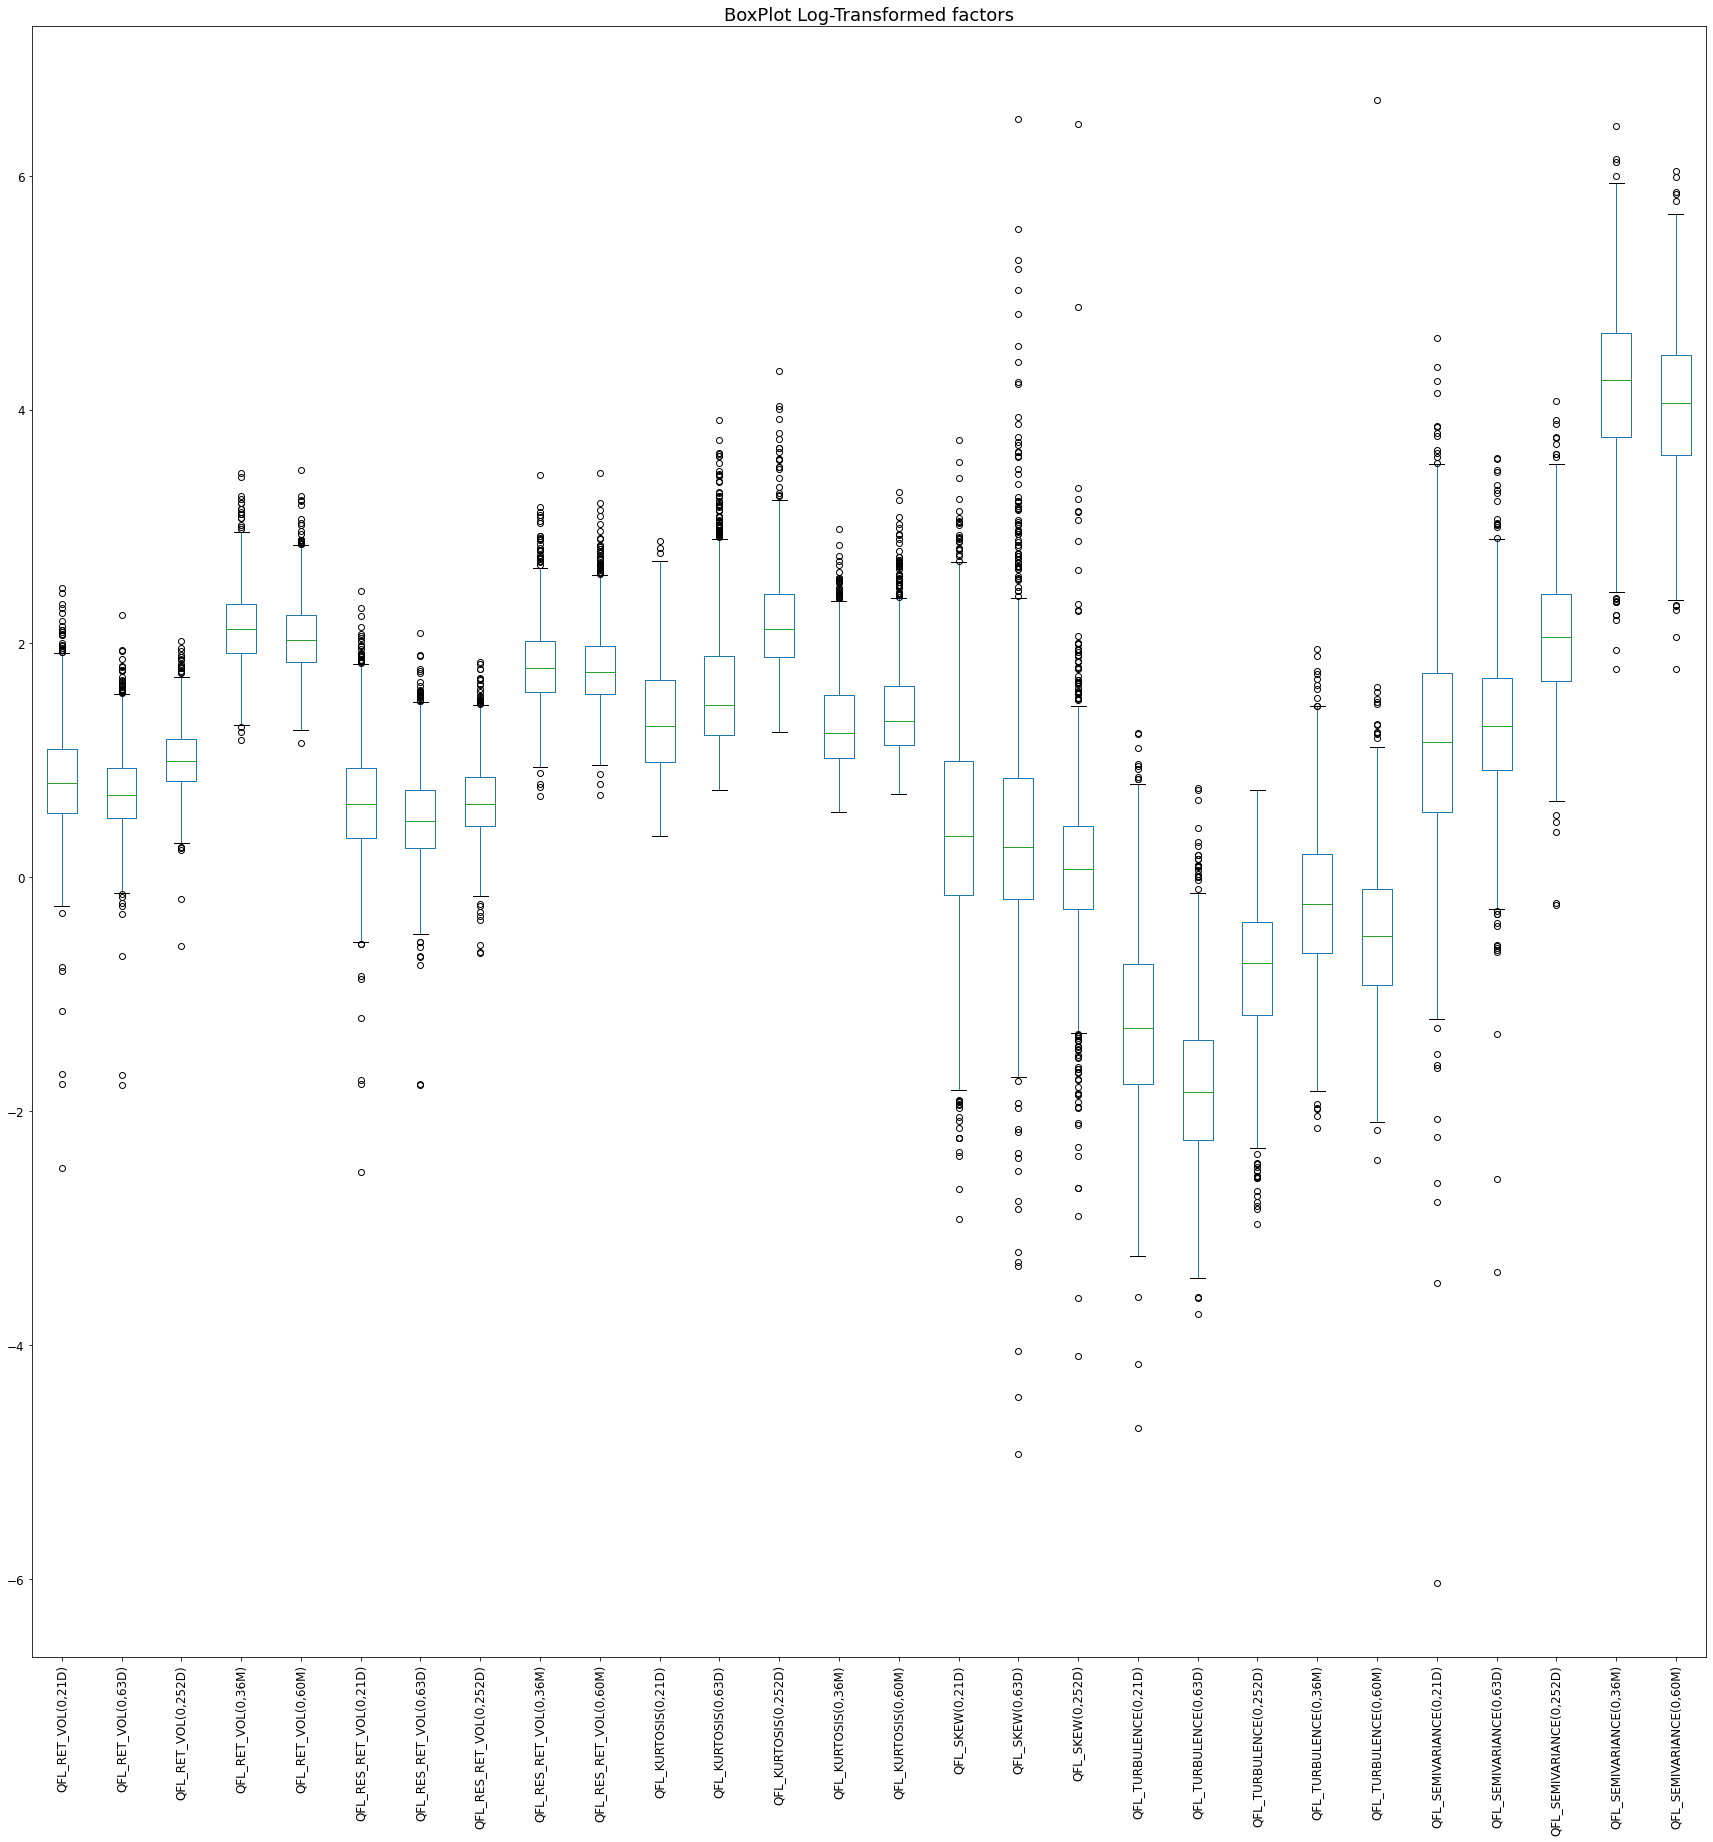

In [40]:
# Box-Whisker plot of Log-Transformed data

qfl_df_log.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Log-Transformed factors', fontsize = 18);

In [41]:
# MFR Z-Score of Log-Transformed and Z-Scored data

# Z-Score of Log-Transformed data

qfl_df_log_z = pd.DataFrame()

for factor in qfl_df_log:
    z_score = ( qfl_df_log[factor] - qfl_df_log[factor].mean() ) / qfl_df_log[factor].std()
    qfl_df_log_z[factor] = z_score

qfl_df_log_z['MFR'] = qfl_df_log_z.mean(axis = 1)

qfl_df_log_z.head()

,"QFL_RET_VOL(0,21D)","QFL_RET_VOL(0,63D)","QFL_RET_VOL(0,252D)","QFL_RET_VOL(0,36M)","QFL_RET_VOL(0,60M)","QFL_RES_RET_VOL(0,21D)","QFL_RES_RET_VOL(0,63D)","QFL_RES_RET_VOL(0,252D)","QFL_RES_RET_VOL(0,36M)","QFL_RES_RET_VOL(0,60M)","QFL_KURTOSIS(0,21D)","QFL_KURTOSIS(0,63D)","QFL_KURTOSIS(0,252D)","QFL_KURTOSIS(0,36M)","QFL_KURTOSIS(0,60M)","QFL_SKEW(0,21D)","QFL_SKEW(0,63D)","QFL_SKEW(0,252D)","QFL_TURBULENCE(0,21D)","QFL_TURBULENCE(0,63D)","QFL_TURBULENCE(0,252D)","QFL_TURBULENCE(0,36M)","QFL_TURBULENCE(0,60M)","QFL_SEMIVARIANCE(0,21D)","QFL_SEMIVARIANCE(0,63D)","QFL_SEMIVARIANCE(0,252D)","QFL_SEMIVARIANCE(0,36M)","QFL_SEMIVARIANCE(0,60M)",MFR
0,-0.636537,0.739480,0.185263,0.516825,0.475634,-0.496118,-0.038340,-0.595610,0.405824,0.345015,-0.598112,-0.620356,-0.573672,-0.483730,-0.580644,-0.102464,-0.801366,-0.205457,-0.173613,-0.559281,0.184496,0.262797,-0.079223,-0.612507,1.361051,0.240077,0.153716,0.242061,-0.073028
1,-0.487008,0.095911,0.004491,-1.170092,-1.155215,-0.689166,-1.047484,-1.250648,-1.779237,-1.375702,-0.251596,-0.618626,0.172166,-0.911986,-0.934755,0.011595,-0.829160,-0.205850,-0.736863,-1.896186,0.468686,-0.591235,-1.099343,-0.282914,0.840884,0.178173,-1.157634,-1.170301,-0.638182
2,-0.010541,0.569955,-0.448455,0.257579,0.210090,0.177797,0.117744,-0.045599,0.344421,0.220511,0.384611,-0.992642,-1.769518,0.431645,0.209752,-0.145329,-0.218269,0.020203,-0.971882,-0.571279,-0.364958,-0.940312,-0.963185,0.391773,0.925768,-0.540680,0.271289,0.225981,-0.115126
3,0.188934,0.615042,0.148109,0.287168,0.066024,0.166433,0.271856,-0.062599,-0.076396,-0.024755,1.146560,-0.422860,-0.687587,-0.411020,-0.262314,0.772777,-0.129048,-0.425013,-0.037855,-0.342234,-0.070227,0.429180,NaN,0.032822,0.827486,0.278324,0.006248,-0.132774,0.079714
4,-0.768865,0.001043,-0.473617,-0.408743,-0.545429,-1.153373,-0.776318,-1.332611,-0.845274,-0.808700,1.399831,-0.595659,-0.625836,-0.841777,-0.906287,1.329799,-0.597483,-0.424113,-0.180382,-0.337306,-0.430438,-0.490857,NaN,-1.126403,0.588577,-0.151595,-0.282320,-0.307449,-0.410799


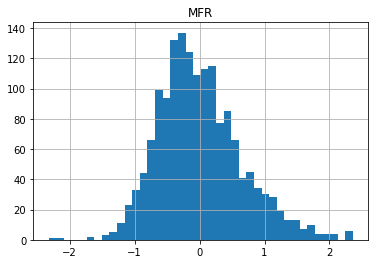

In [42]:
# MFR Distribution (of Log-Transformed and Z-Score factors)

pd.DataFrame(qfl_df_log_z['MFR']).hist(bins = int(np.sqrt(len(qfl_df_log_z['MFR']))));

In [43]:
# Check Infomation Coefficient: MRF (Components: All, Z-Scored & Log-Transformed)

sp_corr_z_log, sp_pval_z_log = stats.spearmanr(-qfl_df_log_z['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z_log,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_log,2)))

Information Coefficient: -0.18
Information Coefficient (P-Value): 0.0


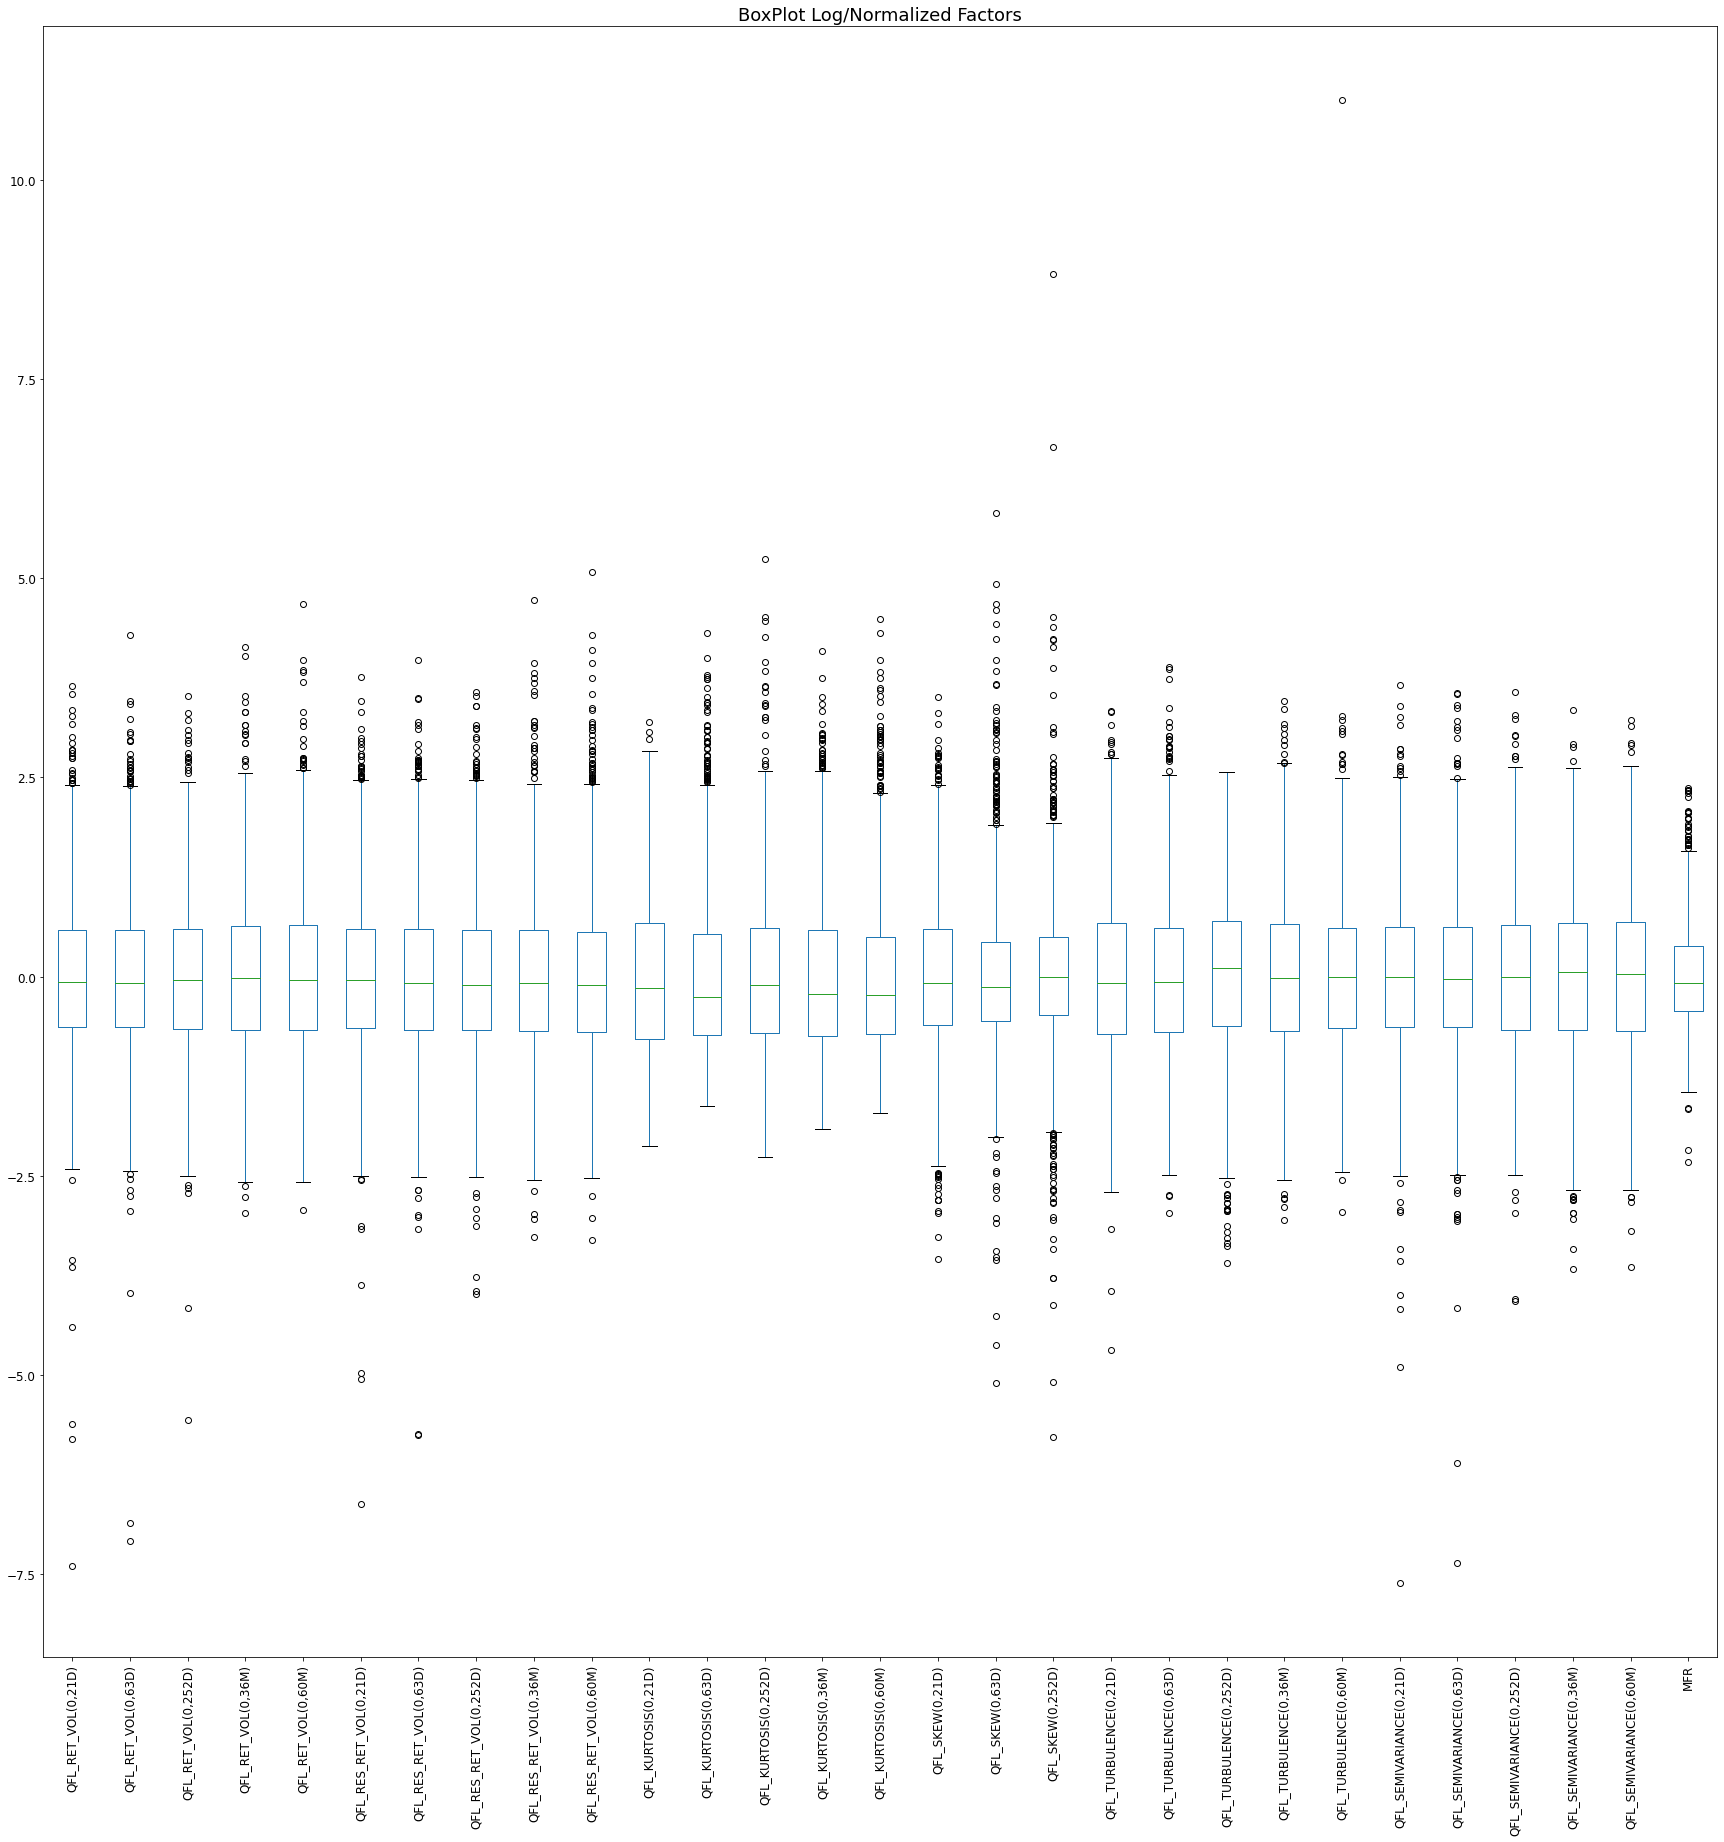

In [44]:
# Box-Whisker plot of Log-Transformed and Z-Score data

qfl_df_log_z.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Log/Normalized Factors', fontsize = 18);

In [45]:
# Check Universe Exposures (Geography, Size, Sector)

qfl_df['ison_screen'] = 1

qfl_df.head()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,"QFL_RET_VOL(0,21D)","QFL_RET_VOL(0,63D)","QFL_RET_VOL(0,252D)","QFL_RET_VOL(0,36M)","QFL_RET_VOL(0,60M)","QFL_RES_RET_VOL(0,21D)","QFL_RES_RET_VOL(0,63D)","QFL_RES_RET_VOL(0,252D)","QFL_RES_RET_VOL(0,36M)","QFL_RES_RET_VOL(0,60M)","QFL_KURTOSIS(0,21D)","QFL_KURTOSIS(0,63D)","QFL_KURTOSIS(0,252D)","QFL_KURTOSIS(0,36M)","QFL_KURTOSIS(0,60M)","QFL_SKEW(0,21D)","QFL_SKEW(0,63D)","QFL_SKEW(0,252D)","QFL_SKEW(0,36M)","QFL_SKEW(0,60M)","QFL_TURBULENCE(0,21D)","QFL_TURBULENCE(0,63D)","QFL_TURBULENCE(0,252D)","QFL_TURBULENCE(0,36M)","QFL_TURBULENCE(0,60M)","QFL_SEMIVARIANCE(0,21D)","QFL_SEMIVARIANCE(0,63D)","QFL_SEMIVARIANCE(0,252D)","QFL_SEMIVARIANCE(0,36M)","QFL_SEMIVARIANCE(0,60M)",ison_screen
0,890100,30-Nov-2020,03783310,4.204100,Apple Inc.,Information Technology,United States,11.457372,Mega Cap,2024064.4,1.736181,2.685291,2.904409,9.947263,8.957233,1.509390,1.646120,1.597132,7.081171,6.721782,2.940706,3.604118,6.932497,3.101996,3.280992,0.326973,-0.442925,-0.071032,0.078083,0.029090,0.256205,0.115419,0.502005,0.944721,0.575369,1.785452,8.868933,8.954514,74.491580,65.849396,1
1,890100,30-Nov-2020,59491810,3.141281,Microsoft Corporation,Information Technology,United States,3.900588,Mega Cap,1618475.4,1.856759,2.140169,2.757432,5.783602,5.432563,1.376211,1.102639,1.287538,3.348038,3.815889,3.465580,3.607439,9.419123,2.609282,2.831413,0.434648,-0.471974,-0.071315,-0.457086,-0.350548,0.168773,0.048011,0.595506,0.552488,0.296581,2.437733,6.366518,8.647545,31.324337,27.422405,1
2,890100,30-Nov-2020,02313510,2.735749,"Amazon.com, Inc.",Consumer Discretionary,United States,2.805829,Mega Cap,1589567.8,2.299716,2.529494,2.421004,9.151896,8.256828,2.083745,1.751372,1.913891,6.933672,6.451979,4.685197,2.956184,4.240813,4.489589,4.558913,0.286507,0.166507,0.091652,-0.115137,-0.181990,0.141795,0.114514,0.360821,0.443705,0.324009,4.611284,6.720408,5.767320,80.507950,65.195900,1
3,890100,30-Nov-2020,30303M10,1.356526,"Facebook, Inc. Class A",Communication Services,United States,-1.375598,Mega Cap,665827.3,2.515214,2.570025,2.873575,9.239359,7.900032,2.072446,1.861895,1.903218,6.002215,5.951751,6.722979,4.003663,6.615421,3.194443,3.745762,1.153225,0.259757,-0.229315,0.501625,0.453255,0.283323,0.133083,0.430746,1.048801,NaN,3.285019,6.312389,9.149596,67.576980,52.189465,1
4,890100,30-Nov-2020,02079K10,1.085045,Alphabet Inc. Class C,Communication Services,United States,-0.503194,Mega Cap,580810.4,1.636021,2.069769,2.403568,7.387337,6.549465,1.102098,1.227994,1.253287,4.611476,4.598537,7.580421,3.651815,6.785458,2.684332,2.865158,1.679069,-0.229834,-0.228666,-0.265110,-0.235695,0.254923,0.133514,0.346897,0.588445,NaN,1.098721,5.420876,7.181109,55.848140,46.830730,1


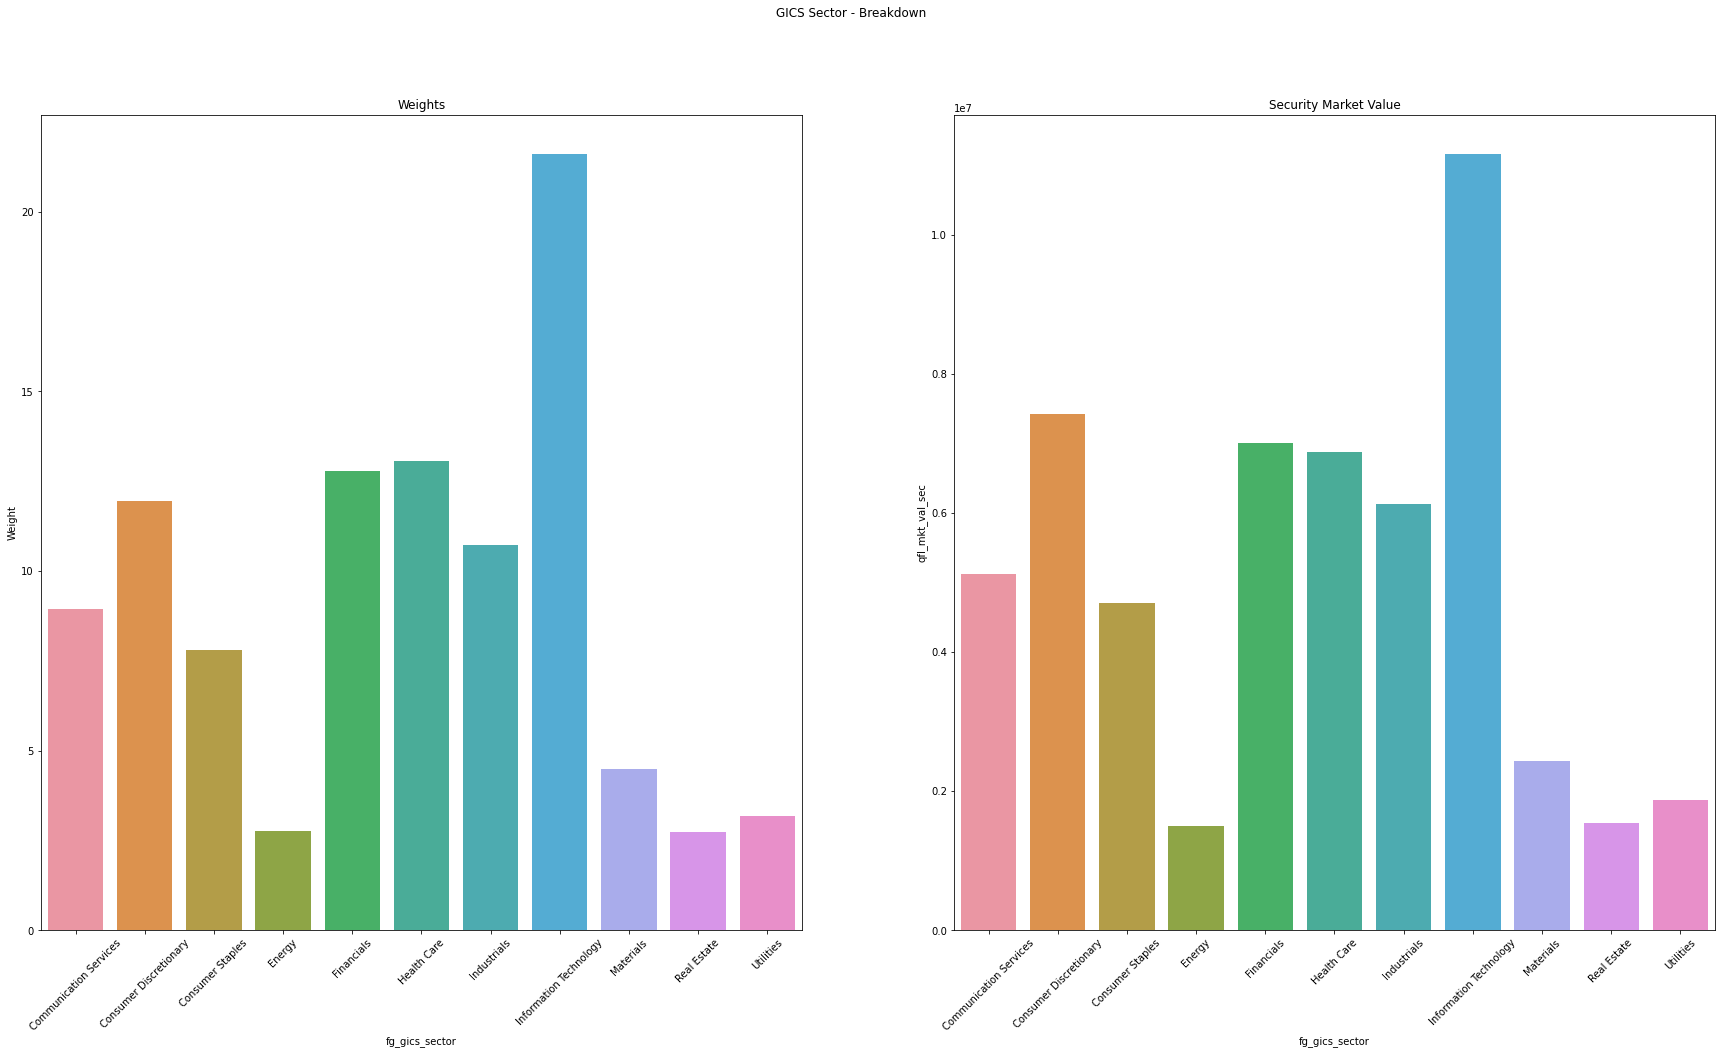

In [46]:
# Group universe

# GICS Sector
GICS_grouped = qfl_df.groupby('fg_gics_sector').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('GICS Sector - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('Security Market Value')

chart = sns.barplot(ax=axes[0], x = GICS_grouped.index, y = 'Weight', data = GICS_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = GICS_grouped.index, y = 'qfl_mkt_val_sec', data = GICS_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

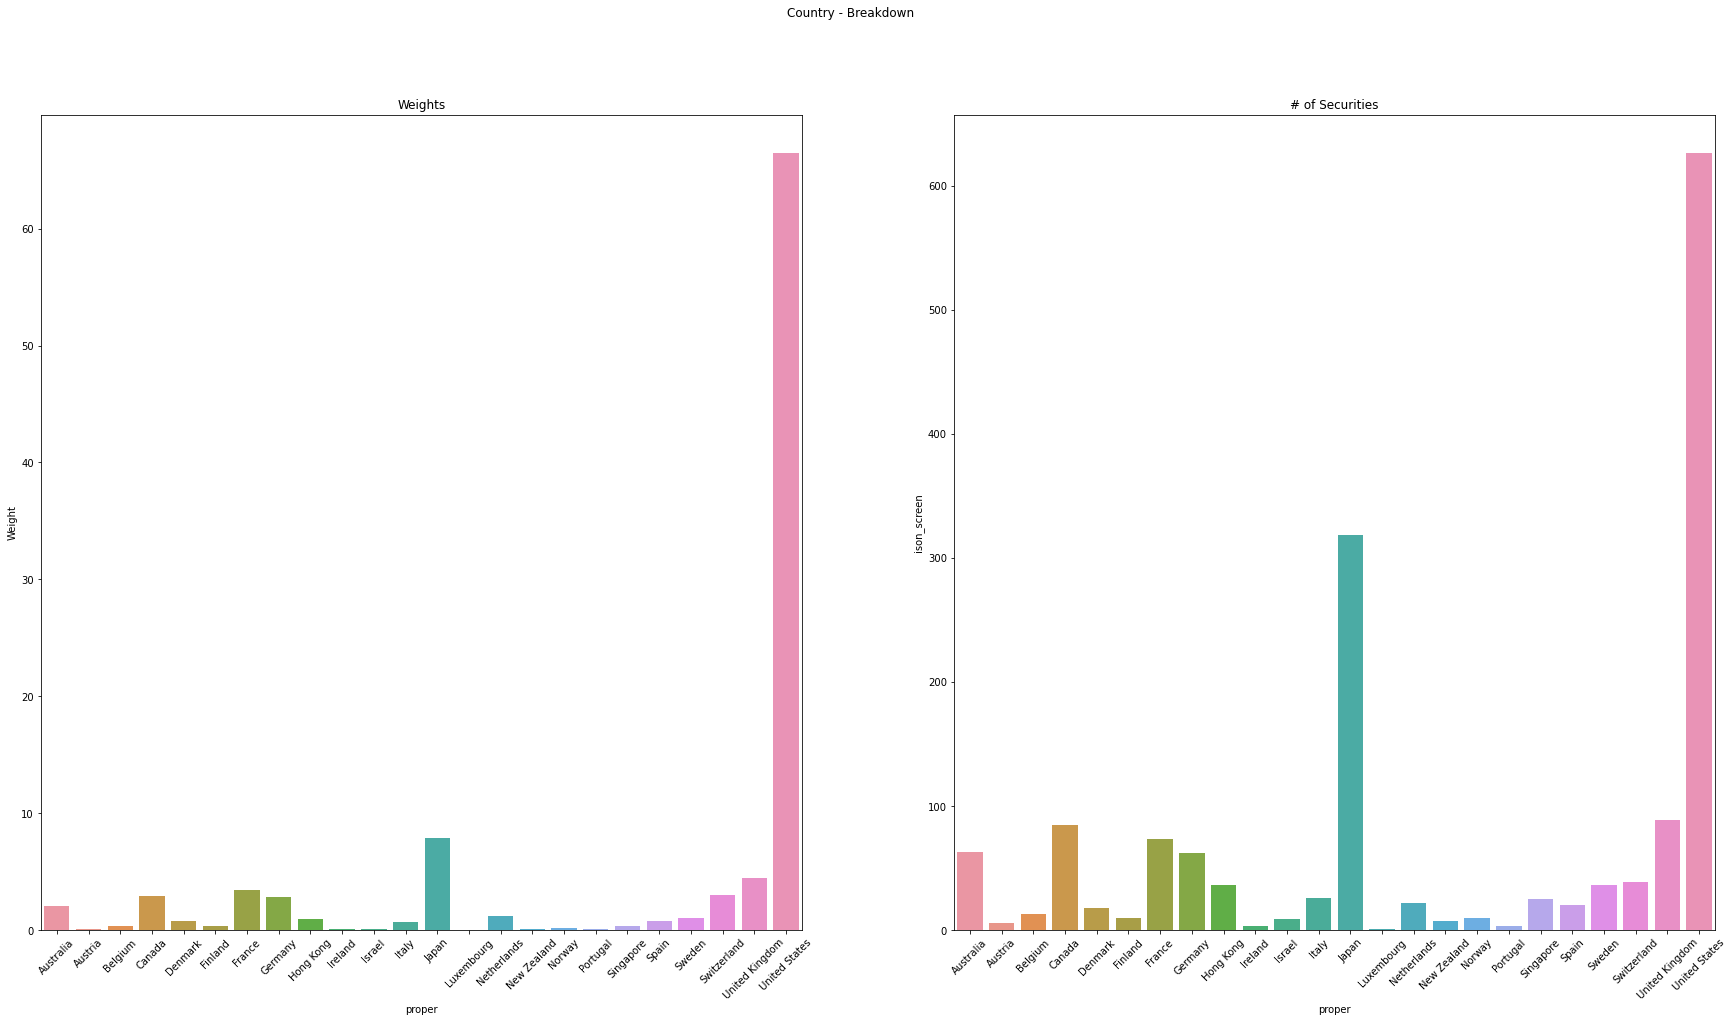

In [47]:
# Group universe

# Country
Country_grouped = qfl_df.groupby('proper').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Country - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('# of Securities')

chart = sns.barplot(ax=axes[0], x = Country_grouped.index, y = 'Weight', data = Country_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = Country_grouped.index, y = 'ison_screen', data = Country_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

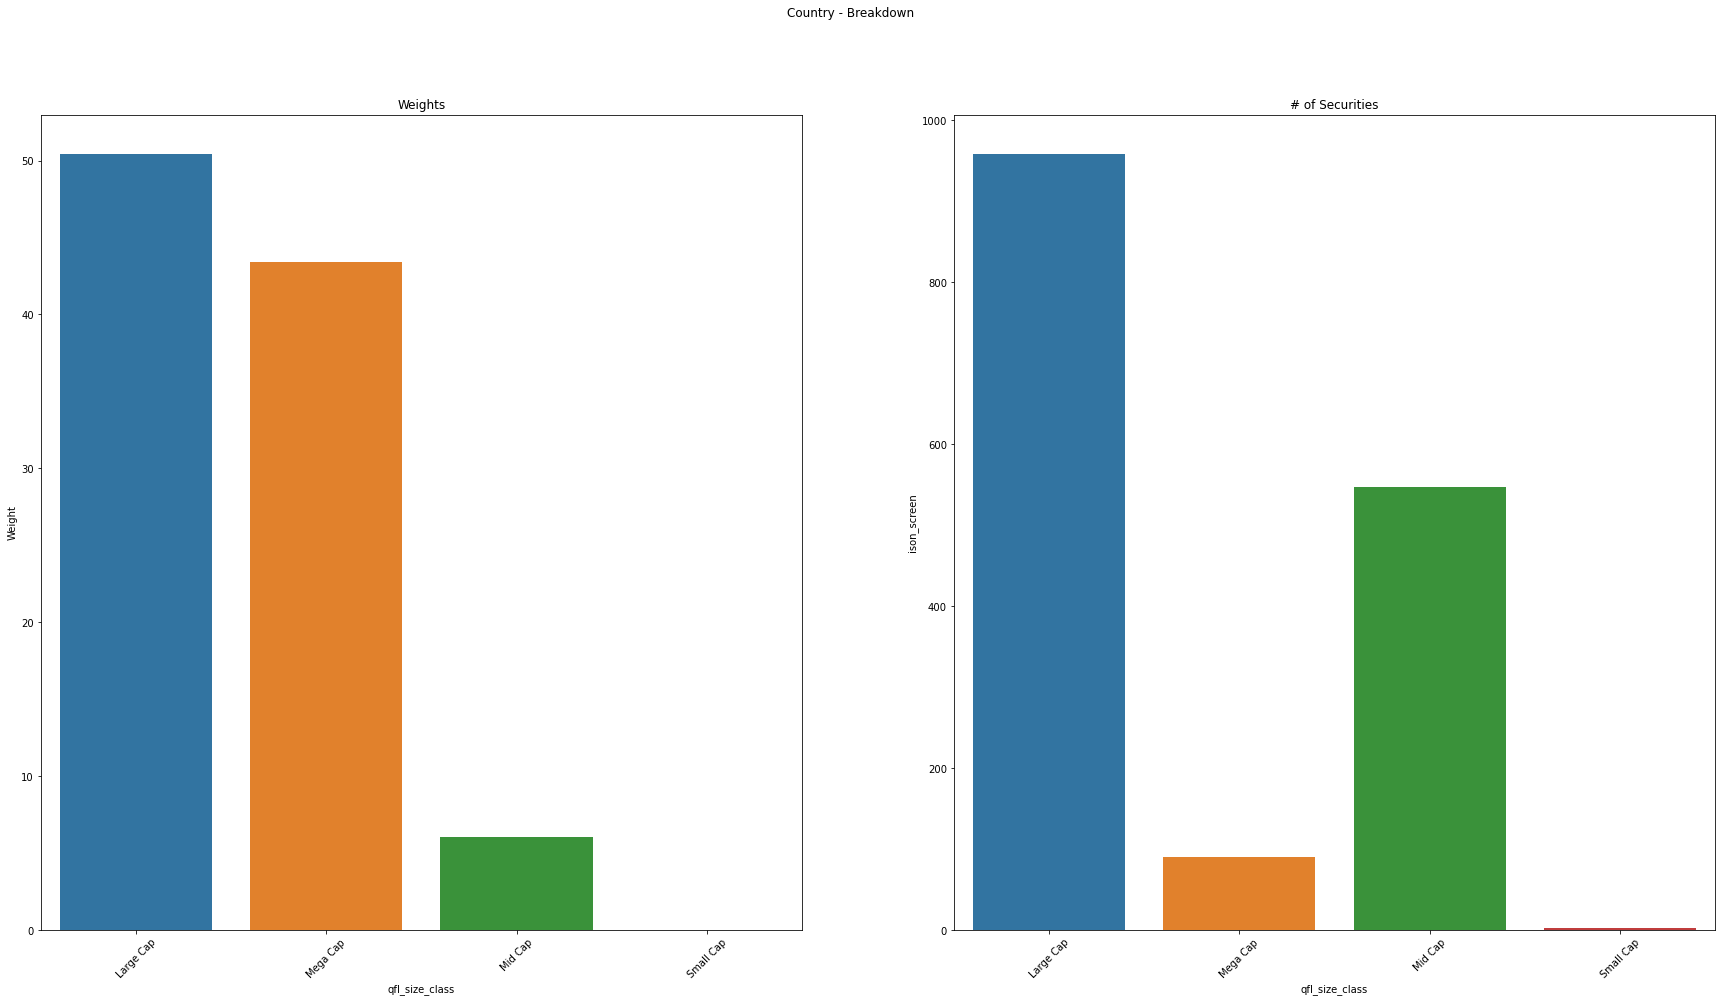

In [48]:
# Group universe

# Size
Size_grouped = qfl_df.groupby('qfl_size_class').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Country - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('# of Securities')

chart = sns.barplot(ax=axes[0], x = Size_grouped.index, y = 'Weight', data = Size_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = Size_grouped.index, y = 'ison_screen', data = Size_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

In [49]:
# Feature Selection

In [50]:
# Discard features with more than 80 NAs

qfl_filtered = qfl_df[qfl_df[qfl_df.columns[filter_idx]].isna().sum(axis = 0)[qfl_df[qfl_df.columns[filter_idx]].isna().sum(axis = 0) < 80].index]

In [51]:
# Replace NAs for retained features with feature's average

for col in qfl_filtered.columns:
    qfl_filtered[col] = qfl_filtered[col].replace(np.nan, qfl_filtered[col].mean(axis = 0))
    
qfl_df['p_total_return'] = qfl_df['p_total_return'].replace(np.nan, 0);

<ipython-input-51-d861f91d7765>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qfl_filtered[col] = qfl_filtered[col].replace(np.nan, qfl_filtered[col].mean(axis = 0))


In [52]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

X = qfl_filtered
Y = qfl_df['p_total_return']

#RECURSIVE FEATURE ELIMINATION

lin_reg = Lasso()
rfe = RFE(lin_reg, n_features_to_select=3, step = 1)
fit_rfe = rfe.fit(X, Y)
print("Num Features: %s" % (fit_rfe.n_features_))
print("Selected Features: %s" % (fit_rfe.support_))
print("Feature Ranking: %s" % (fit_rfe.ranking_))


Num Features: 3
Selected Features: [False False False False False False False False False False  True  True
 False False False False False False False False  True False]
Feature Ranking: [20 19 18 17 16 15 14 13 12 11  1  1 10  9  8  7  6  5  3  4  1  2]


In [53]:
qfl_filtered.columns[fit_rfe.support_]

Index(['QFL_KURTOSIS(0,252D)', 'QFL_KURTOSIS(0,36M)',
       'QFL_SEMIVARIANCE(0,252D)'],
      dtype='object')

In [54]:
qfl_filtered[qfl_filtered.columns[fit_rfe.support_]].corr()

,"QFL_KURTOSIS(0,252D)","QFL_KURTOSIS(0,36M)","QFL_SEMIVARIANCE(0,252D)"
"QFL_KURTOSIS(0,252D)",1.000000,0.271599,0.161679
"QFL_KURTOSIS(0,36M)",0.271599,1.000000,0.364849
"QFL_SEMIVARIANCE(0,252D)",0.161679,0.364849,1.000000


In [55]:
qfl_filtered[qfl_filtered.columns[fit_rfe.support_]]

,"QFL_KURTOSIS(0,252D)","QFL_KURTOSIS(0,36M)","QFL_SEMIVARIANCE(0,252D)"
0,6.932497,3.101996,8.954514
1,9.419123,2.609282,8.647545
2,4.240813,4.489589,5.767320
3,6.615421,3.194443,9.149596
4,6.785458,2.684332,7.181109
...,...,...,...
1595,16.497278,12.929531,11.847862
1596,5.278915,1.976604,2.570133
1597,11.145532,10.302603,11.013357
1598,4.246416,2.284090,10.733218


In [56]:
# MFR Z-Score after Feature Selection

qfl_mfr_RFE = pd.DataFrame()

for factor in qfl_filtered[qfl_filtered.columns[fit_rfe.support_]]:
    z_score_RFE = ( qfl_filtered[factor] - qfl_filtered[factor].mean() ) / qfl_filtered[factor].std()
    qfl_mfr_RFE[factor] = z_score_RFE

qfl_mfr_RFE['MFR'] = qfl_mfr_RFE.mean(axis = 1)

qfl_mfr_RFE.head()

,"QFL_KURTOSIS(0,252D)","QFL_KURTOSIS(0,36M)","QFL_SEMIVARIANCE(0,252D)",MFR
0,-0.524081,-0.506787,-0.041425,-0.357431
1,-0.044508,-0.748698,-0.094218,-0.295808
2,-1.043201,0.174491,-0.589561,-0.486090
3,-0.585232,-0.461397,-0.007875,-0.351501
4,-0.552439,-0.711850,-0.346416,-0.536902


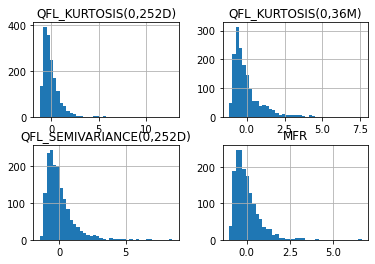

In [57]:
qfl_mfr_RFE.hist(bins = int(np.sqrt(len(qfl_mfr_RFE['MFR']))));

In [58]:
# Check Infomation Coefficient: MFR (Components: RFE's Feature Selected, Z-Scored)

sp_corr_z_rfe, sp_pval_z_rfe = stats.spearmanr(-qfl_mfr_RFE['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z_rfe,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_rfe,2)))

Information Coefficient: -0.08
Information Coefficient (P-Value): 0.0


# Information Coefficient Summary (LVRB)

### Feature Selection: Recoursive Feature Elimination (RFE + Lasso) (3 Top Components)

In [59]:
print('Information Coefficient: {0}'.format(round(sp_corr_z_rfe,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_rfe,2)))

Information Coefficient: -0.08
Information Coefficient (P-Value): 0.0


### Z-Score + Log-Transformation (All Components)

In [60]:
print('Information Coefficient: {0}'.format(round(sp_corr_z_log,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_log,2)))

Information Coefficient: -0.18
Information Coefficient (P-Value): 0.0


### Z-Score Only (All Components)

In [61]:
print('Information Coefficient: {0}'.format(round(sp_corr_z,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z,2)))

Information Coefficient: 0.05
Information Coefficient (P-Value): 0.04
